# **TUGAS 2 : Unsupervised Learning**

**KELOMPOK 7** :

Gaung Taqwa Indraswara (235150207111043)

Muhammad Fauzan (235150201111044)

Ferrel Destatiananda Edwardo (235150207111044)

Muhammad Fatir Zaira (23515020011039)

# **IMPORT LIBRARIES**

In [ ]:
import pandas as pd
import kagglehub
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
from random import randint
import copy

# **LOADING DATA**

In [ ]:
# Download latest version
path = kagglehub.dataset_download("vetrirah/customer")

print("Path to dataset files:", path)

100%|██████████| 105k/105k [00:00<00:00, 60.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/vetrirah/customer/versions/1


In [ ]:
print(os.listdir(path))

['Test.csv', 'Train.csv', 'sample_submission.csv']


In [ ]:
data_train = pd.read_csv(os.path.join(path, "Train.csv"))
data_test = pd.read_csv(os.path.join(path, "Test.csv"))
sample_submission = pd.read_csv(os.path.join(path, "sample_submission.csv"))

In [ ]:
# # Simpan Raw dataset dalam bentuk CSV
# data_train.to_csv('raw_dataset.csv', index=False)

# **DATA UNDERSTANDING**

## **Deskripsi Dataset**

- `data_train` = digunakan untuk `training` model
- `data_test` = digunakan untuk `menguji performa` model yang telah dilatih.
- `sample_submission` = contoh sample submission atau `output` yang diberikan oleh sumber (kaggle)

In [ ]:
data_train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [ ]:
data_test.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6


In [ ]:
sample_submission.head()

,ID,Segmentation
0,458989,A
1,458994,A
2,458996,A
3,459000,A
4,459001,A


untuk tugas kali ini kami hanya menggunakan data_train saja untuk modelling dan juga agar bisa melakukan evaluasi eksternal nantinya, untuk data_test dan submission_sample untuk sementara kami biarkan

## **Deskripsi Fitur**

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


Terlihat ada beberapa null rows di fitur fitur ini:
`Ever_Married`, `Graduated`, `Profession`, `Work_Experience`, `Family_Size` dan `Var_1` yang akan kita lakukan analisis lebih lanjut di section berikutnya untuk menentukan penangnan yang optimal

In [ ]:
unique_c = data_train.nunique()
unique_v = {col: data_train[col].unique() for col in data_train.columns}

df_unique = pd.DataFrame({
    'Column': unique_c.index,
    'Unique Count': unique_c.values,
    'Unique Values': [unique_v[col] for col in unique_c.index]
})

df_unique

,Column,Unique Count,Unique Values
0,ID,8068,"[462809, 462643, 466315, 461735, 462669, 46131..."
1,Gender,2,"[Male, Female]"
2,Ever_Married,2,"[No, Yes, nan]"
3,Age,67,"[22, 38, 67, 40, 56, 32, 33, 61, 55, 26, 19, 7..."
4,Graduated,2,"[No, Yes, nan]"
5,Profession,9,"[Healthcare, Engineer, Lawyer, Entertainment, ..."
6,Work_Experience,15,"[1.0, nan, 0.0, 4.0, 9.0, 12.0, 3.0, 13.0, 5.0..."
7,Spending_Score,3,"[Low, Average, High]"
8,Family_Size,9,"[4.0, 3.0, 1.0, 2.0, 6.0, nan, 5.0, 8.0, 7.0, ..."
9,Var_1,7,"[Cat_4, Cat_6, Cat_7, Cat_3, Cat_1, Cat_2, nan..."


Berikut adalah deskripsi fitur yang diberikan oleh pengupload dataset di kaggle

#### **RINGKASAN**

| Kolom             | Tipe Data       | Deskripsi                                                                |
| ----------------- | --------------- | ------------------------------------------------------------------------ |
| `ID`              | Numerik (int)   | ID unik setiap pelanggan.  |
| `Gender`          | Kategori        | Jenis kelamin pelanggan (`Male`, `Female`).                              |
| `Ever_Married`    | Kategori        | Status pernikahan pelanggan (`Yes`, `No`).                                         |
| `Age`             | Numerik (int)   | Usia pelanggan.                                                          |
| `Graduated`       | Kategori        | Status kelulusan pendidikan tinggi pelanggan (`Yes`, `No`).                        |
| `Profession`      | Kategori        | Pekerjaan pelanggan (misalnya: `Healthcare`, `Engineer`, `Lawyer`, dll). |
| `Work_Experience` | Numerik (float) | Lama pengalaman kerja (dalam tahun). Bisa bernilai NaN (hilang).         |
| `Spending_Score`  | Kategori        | Kategori pengeluaran: `Low`, `Average`, `High`.                          |
| `Family_Size`     | Numerik (float) | Jumlah anggota keluarga dalam rumah tangga.                              |
| `Var_1`           | Kategori        | Ini adalah kolom kategori yang disamarkan. (mungkin bisa merepresentasikan segmen, perilaku, atau preferensi tapi dirahasiakan).    |
| `Segmentation`    | Kategori        | **Target label** segmentasi pelanggan: `A`, `B`, `C`, `D`.               |

di dataset ini sudah terdapat label/ground truth di fitur `Segmentation` yang berjumlah 4 cluster, dengan ini memungkinkan kami melakukan external evaluation nantinya

## **Persebaran Data**

In [ ]:
print("Jumlah baris dan kolom:", data_train.shape)

Jumlah baris dan kolom: (8068, 11)


In [ ]:
data_train.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [ ]:
data_train.describe(include='object')

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
count,8068,7928,7990,7944,8068,7992,8068
unique,2,2,2,9,3,7,4
top,Male,Yes,Yes,Artist,Low,Cat_6,D
freq,4417,4643,4968,2516,4878,5238,2268


persebaran label segmentasi dibawah ini hanya dari data train saja karena saja test tidak memiliki kolom `Segmentation`

In [ ]:
print(data_train['Segmentation'].value_counts())

Segmentation
D    2268
A    1972
C    1970
B    1858
Name: count, dtype: int64


In [ ]:
data_train.isnull().sum()

,0
ID,0
Gender,0
Ever_Married,140
Age,0
Graduated,78
Profession,124
Work_Experience,829
Spending_Score,0
Family_Size,335
Var_1,76


Sama seperti tadi, terlihat ada beberapa null rows di fitur fitur ini:
`Ever_Married`, `Graduated`, `Profession`, `Work_Experience`, `Family_Size` dan `Var_1` yang akan kita lakukan analisis lebih lanjut di section berikutnya untuk menentukan penangnan yang optimal

In [ ]:
print("Jumlah baris duplikat:", data_train.duplicated().sum())

Jumlah baris duplikat: 0


tidak ada baris yang duplikat sama sekali di data_train ini

# **EDA (Exploratory Data Analysis)**

In [ ]:
# Persiapan data untuk EDA
num = data_train.select_dtypes(include=['int64', 'float64'])
num = num.drop(columns=['ID'])
cat = data_train.select_dtypes(include=['object', 'category'])
cat = cat.drop(columns=['Segmentation'])

## **Distribusi Segmentasi**

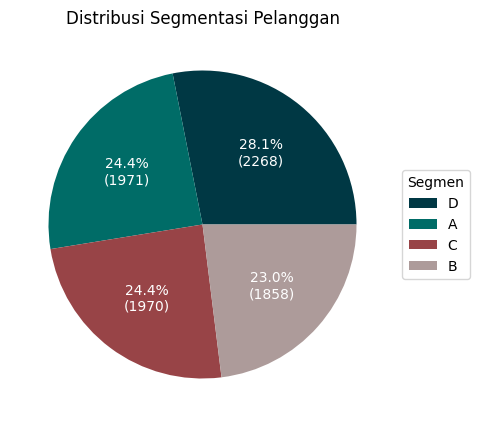

In [ ]:
segment_counts = data_train['Segmentation'].value_counts()
colors = ['#003844','#006C67','#984447','#AD9B9A']
plt.figure(figsize=(5, 5))
plt.pie(segment_counts,
        labels=segment_counts.index,
        colors=colors,
        textprops={'color': 'white'},
        autopct=lambda p: f'{p:.1f}%\n({int(p * sum(segment_counts)/100)})')


labels = [f"{label} " for label, count in zip(segment_counts.index, segment_counts)]
plt.legend(labels, title="Segmen", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Distribusi Segmentasi Pelanggan')
plt.show()

terlihat persebaran cukup mereta untuk setiap kelas segmentasi yang diberikan di train set, dengan segmen D yang paling dominan

## **Distribusi Fitur**

### **Fitur Numerik**

In [ ]:
data_train[num.columns].describe()

,Age,Work_Experience,Family_Size
count,8068.000000,7239.000000,7733.000000
mean,43.466906,2.641663,2.850123
std,16.711696,3.406763,1.531413
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,40.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,89.000000,14.000000,9.000000


In [ ]:
print("Unique values dan jumlahnya untuk Work_Experience:")
print(data_train['Work_Experience'].value_counts())

print("\nUnique values dan jumlahnya untuk Family_Size:")
print(data_train['Family_Size'].value_counts())

print("\nUnique values dan jumlahnya untuk Age:")
print(data_train['Age'].value_counts())

Unique values dan jumlahnya untuk Work_Experience:
Work_Experience
1.0     2354
0.0     2318
9.0      474
8.0      463
2.0      286
3.0      255
4.0      253
6.0      204
7.0      196
5.0      194
10.0      53
11.0      50
12.0      48
13.0      46
14.0      45
Name: count, dtype: int64

Unique values dan jumlahnya untuk Family_Size:
Family_Size
2.0    2390
3.0    1497
1.0    1453
4.0    1379
5.0     612
6.0     212
7.0      96
8.0      50
9.0      44
Name: count, dtype: int64

Unique values dan jumlahnya untuk Age:
Age
35    250
37    234
42    232
33    232
27    229
     ... 
78     29
87     28
76     27
80     24
85     22
Name: count, Length: 67, dtype: int64


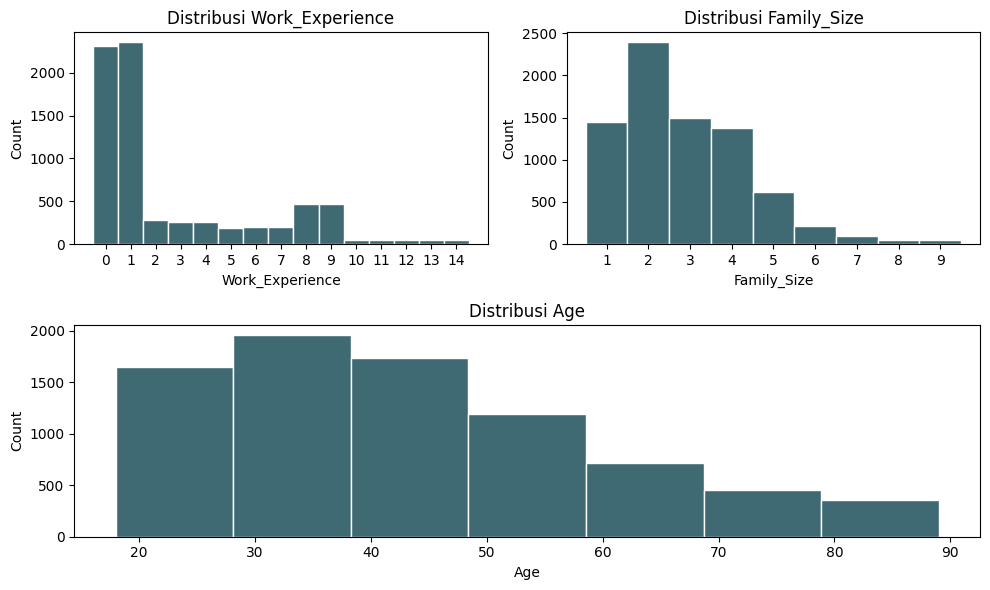

In [ ]:
# Hitung jumlah unique values untuk Work_Experience dan Family_Size
unique_work = data_train['Work_Experience'].nunique()
unique_family = data_train['Family_Size'].nunique()
unique_age = data_train['Age'].nunique()

hist_color = '#003844'
box_color = '#984447'

plt.figure(figsize=(10, 6))

# Plot Work_Experience
plt.subplot(2, 2, 1)
sns.histplot(
    data_train['Work_Experience'],
    bins=unique_work,
    discrete=True,
    color=hist_color,
    edgecolor='white',
)
plt.title('Distribusi Work_Experience')
plt.xticks(range(0, 15))

# Plot Family_Size
plt.subplot(2, 2, 2)
sns.histplot(
    data_train['Family_Size'],
    bins=unique_family,
    discrete=True,
    color=hist_color,
    edgecolor='white',
)
plt.title('Distribusi Family_Size')
plt.xticks(range(1, 10))

# Plot Age
plt.subplot(2, 2, (3,4))
sns.histplot(
    data_train['Age'],
    bins=7,
    color=hist_color,
    edgecolor='white',
)
plt.title('Distribusi Age')

plt.tight_layout()
plt.show()

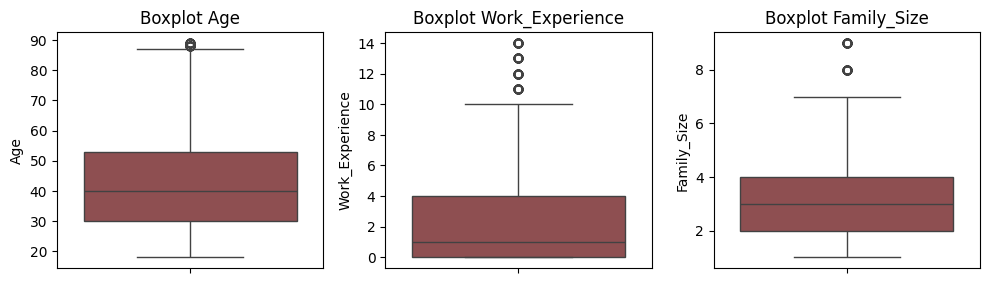

In [ ]:
plt.figure(figsize=(10, 8))
for i, col in enumerate(num.columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=data_train[col], color=box_color)
    plt.title(f'Boxplot {col}')
    plt.tight_layout()
plt.show()

Berdasarkan hasil visualisasi histogram dan boxplot dari ketiga fitur `Age`, `Work_Experience`, dan `Family_Size`, kami memperoleh beberapa insight penting untuk keperluan preprocessing. Distribusi `Age` terlihat right-skewed dan juga menunjukkan kehadiran sedikit outlier pada kelompok usia lanjut (85++). `Work_Experience` sangat condong ke kiri (right skew) dengan mayoritas data berada pada rentang 0–2 tahun, serta terdapat banyak outlier pada nilai tinggi. Selain itu `Family_Size` juga memiliki distribusi yang right skewed, dengan mayoritas ukuran keluarga berada di angka 2 hingga 4, dan juga tetap terdapat beberapa outlier di atas nilai 7. Temuan ini menandakan perlunya penanganan terhadap skala dan distribusi fitur agar hasil clustering lebih optimal.

Sebagai langkah preprocessing, pertama kita akan melakukan penghapusan outlier dengan menggunakan metode IQR. Setelahnya kami akan menerapkan **StandardScaler** pada fitur numerikal diatas untuk menyamakan skala dan mencegah fitur dominan mengganggu hasil clustering. Namun sebelum itu, akan diterapkan **log transformation** terlebih dahulu menggunakan fungsi `log1p` untuk mengatasi kemiringan distribusi (skewness) sebelum dilakukan scaling. Ini dilakukan agar semua fitur lebih mendekati distribusi normal, yang sesuai dengan asumsi dasar StandardScaler.


### **Fitur Non-Numerik**

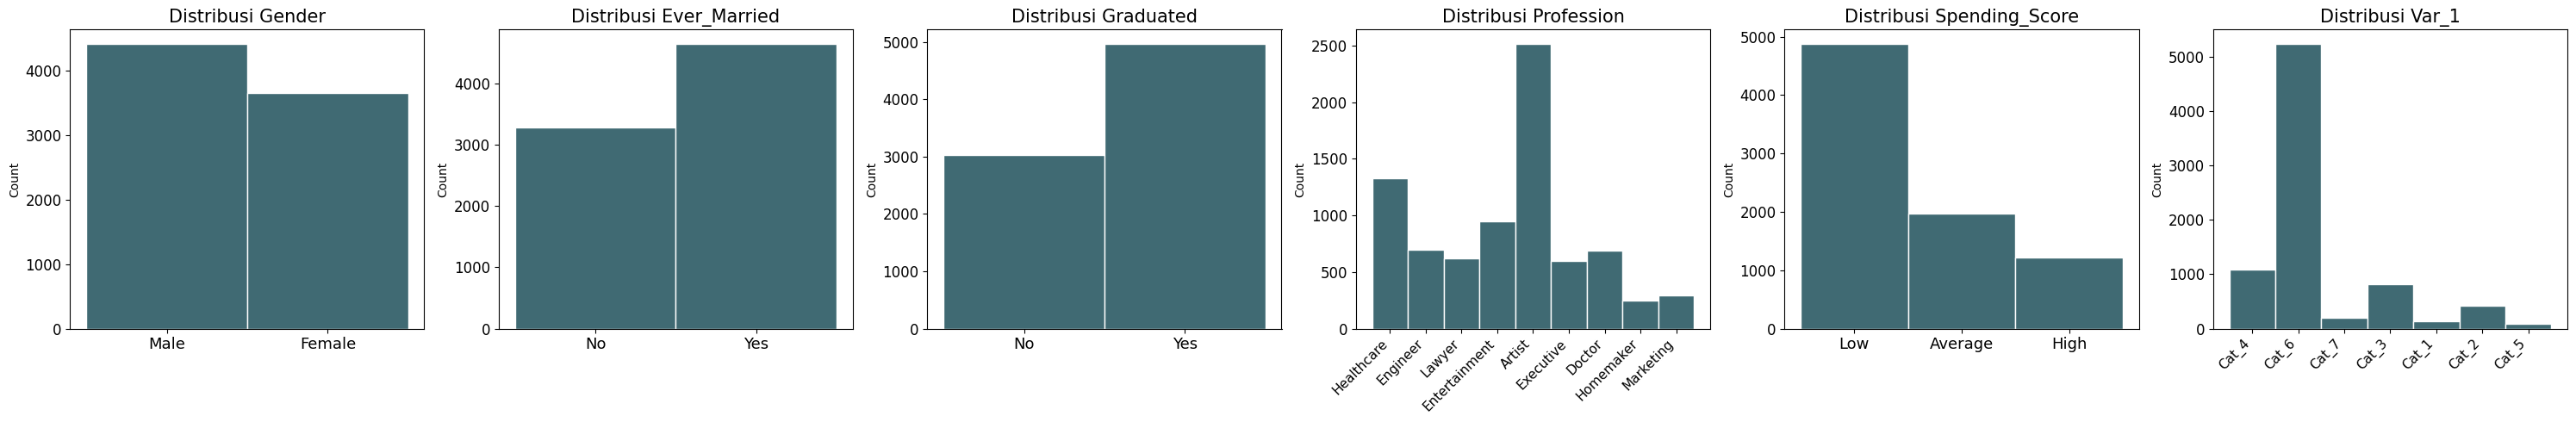

In [ ]:
plt.figure(figsize=(30, 5))
for i, col in enumerate(cat.columns):
    plt.subplot(1, 6, i+1)
    sns.histplot(data_train[col], bins=10, color=hist_color, edgecolor='white', kde=False)
    plt.title(f'Distribusi {col}', fontsize=15)
    plt.xlabel(None)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=12)
    if col == 'Profession' or col == 'Var_1':
        plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.tight_layout()
plt.show()

Dari visualisasi distribusi kategori ini, kita dapat melihat beberapa hal penting. Distribusi antara gender cukup seimbang namun sedikit lebih banyak pria. Mayoritas pelanggan telah/pernah menikah dan lulus pendidikan tinggi, yang bisa menunjukkan segmen pelanggan yang sudah mapan secara sosial dan ekonomi. Profesi “Artist” mendominasi dengan jumlah tertinggi, sementara "Homemaker” memiliki jumlah yang relatif sedikit, hal ini dapat memengaruhi hasil modeling karena distribusi yang tidak seimbang dapat membuat algoritma berat sebelah terhadap kelas mayoritas. Untuk Spending Score, kategori “Low” paling banyak, dan ini bisa menjadi sinyal adanya potensi segmentasi konsumen dengan pengeluaran rendah yang dominan.

Distribusi kolom `Var_1` sangat timpang, dengan mayoritas nilai berada di kategori `Cat_6`. Ketidakseimbangan ini bisa menyebabkan hasil clustering terlalu terpengaruh oleh kategori tersebut. Karena kita tidak mengetahui makna dari `Var_1` dan distribusinya sangat timpang, sebaiknya kolom ini **tidak digunakan terlebih dahulu dalam proses clustering**. Langkah selanjutnya adalah melakukan encoding pada semua fitur kategori (selain ID dan Segmentation yang akan dibuang).

Untuk penanganan fitur kategorikal, pendekatan encoding yang akan digunakan adalah **One-Hot Encoding** untuk fitur kategorikal non-ordinal seperti `Profession`, karena tidak memiliki urutan intrinsik antar kategorinya. Ini akan menghindari asumsi palsu tentang urutan yang bisa membingungkan model berbasis jarak. Sementara itu, untuk fitur `Spending_Score`, akan dilakukan **Ordinal Encoding** karena kategori `Low`, `Average`, dan `High` memiliki urutan alami yang dapat berkontribusi pada pembentukan cluster. Terakhir untuk Fitur-Fitur Biner akan kita lakukan **Label Encoding** agar tidak menambahkan dimensi dari data yang akan sangat berpengaruh bagi perhitungan jarak di algoritma clustering nantinya









## **Heatmap Korelasi Fitur Numerik**

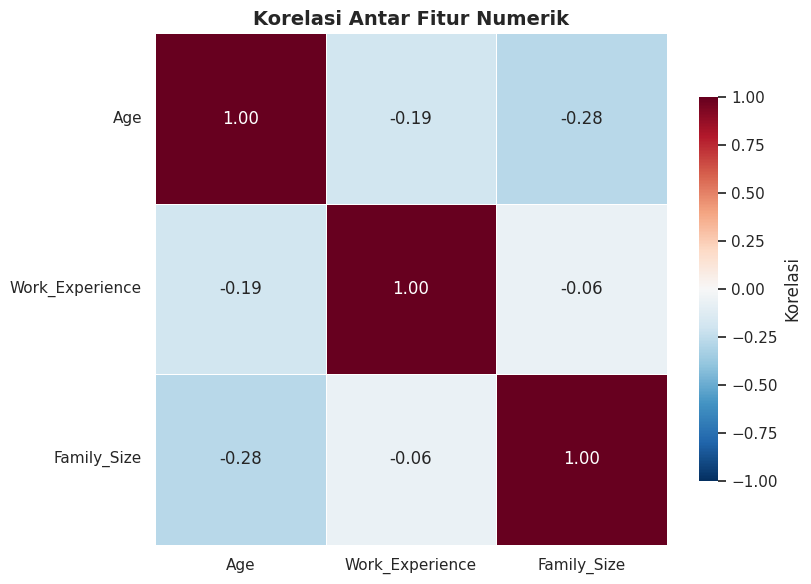

In [ ]:
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
corr = num.corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap='RdBu_r', vmin=-1, vmax=1, linewidths=0.5, square=True, cbar_kws={"shrink": 0.75, "label": "Korelasi"})

plt.title("Korelasi Antar Fitur Numerik", fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Berdasarkan heatmap korelasi yang ditampilkan, terlihat bahwa korelasi antar fitur numerik seperti `Age`, `Work_Experience`, dan `Family_Size` relatif rendah satu sama lain. Nilai korelasi tertinggi (selain diagonal utama) adalah -0.28 antara Age dan Family_Size, yang menunjukkan hubungan negatif lemah. Hal ini menunjukkan bahwa fitur-fitur ini cukup independen dan tidak redundan, sehingga semuanya layak dipertahankan dalam proses clustering karena masing-masing membawa informasi unik.

## **Missing Value Analysis**

di section ini akan kami lakukan analisis terkait missing value untuk melihat pola tertentu tentang missing value dan mencari tahu apakah missing value di dataset ini termasuk Missing at Random (MAR) atau Missing Completly at Random (MCAR)  

In [ ]:
data_train.isnull().sum()

,0
ID,0
Gender,0
Ever_Married,140
Age,0
Graduated,78
Profession,124
Work_Experience,829
Spending_Score,0
Family_Size,335
Var_1,76


In [ ]:
data_missing = data_train.copy()
data_missing = data_missing.drop(columns=['Segmentation'])
missing_rows = data_missing[data_missing.isnull().any(axis=1)]

print("Jumlah baris yang memiliki missing value:", len(missing_rows))
missing_rows.head()

Jumlah baris yang memiliki missing value: 1403


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6
12,461230,Female,No,19,No,Executive,0.0,Low,NaN,Cat_3
13,459573,Male,Yes,70,No,Lawyer,NaN,Low,1.0,Cat_6
24,461021,Female,NaN,58,No,Executive,1.0,Average,3.0,Cat_3


In [ ]:
missing_rows = data_missing[data_missing['Ever_Married'].isnull()]
missing_rows.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
24,461021,Female,NaN,58,No,Executive,1.0,Average,3.0,Cat_3
108,466466,Female,NaN,19,No,Healthcare,6.0,Low,5.0,Cat_3
201,466065,Male,NaN,19,No,Healthcare,9.0,Low,3.0,Cat_3
213,460516,Female,NaN,85,No,Lawyer,0.0,High,1.0,Cat_3
272,464841,Male,NaN,19,No,Entertainment,0.0,High,3.0,Cat_4


In [ ]:
missing_rows = data_missing[data_missing['Graduated'].isnull()]
missing_rows.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
57,462267,Male,No,32,NaN,Doctor,8.0,Low,2.0,Cat_6
220,464613,Female,No,35,NaN,Artist,0.0,Low,3.0,Cat_6
290,465058,Female,No,43,NaN,Entertainment,NaN,Low,1.0,Cat_6
431,462548,Male,No,18,NaN,Executive,NaN,Low,5.0,Cat_4
510,460685,Male,No,51,NaN,Artist,6.0,Low,4.0,Cat_4


In [ ]:
missing_rows = data_missing[data_missing['Profession'].isnull()]
missing_rows.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
79,466567,Female,No,49,Yes,NaN,1.0,Low,1.0,Cat_6
118,465827,Male,No,27,No,NaN,2.0,Low,7.0,Cat_4
219,465837,Male,No,62,Yes,NaN,0.0,Low,1.0,Cat_6
237,467252,Female,No,33,Yes,NaN,0.0,Low,4.0,NaN
437,461410,Male,Yes,79,No,NaN,0.0,Average,2.0,NaN


In [ ]:
missing_rows = data_missing[data_missing['Work_Experience'].isnull()]
missing_rows.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6
13,459573,Male,Yes,70,No,Lawyer,NaN,Low,1.0,Cat_6
39,467442,Male,Yes,56,Yes,Artist,NaN,Average,2.0,Cat_6
45,463156,Female,Yes,79,No,Lawyer,NaN,High,2.0,Cat_6


In [ ]:
missing_rows = data_missing[data_missing['Family_Size'].isnull()]
missing_rows.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
12,461230,Female,No,19,No,Executive,0.0,Low,NaN,Cat_3
33,467010,Male,No,26,No,Homemaker,9.0,Low,NaN,Cat_6
59,460881,Male,Yes,72,Yes,Lawyer,1.0,Low,NaN,Cat_4
112,467758,Female,Yes,50,Yes,Doctor,1.0,Low,NaN,Cat_6
126,466295,Female,Yes,42,No,Engineer,0.0,Low,NaN,Cat_6


In [ ]:
missing_rows = data_missing[data_missing['Var_1'].isnull()]
missing_rows.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
43,466006,Female,Yes,49,Yes,Artist,1.0,Low,2.0,NaN
163,463595,Female,No,32,No,Healthcare,1.0,Low,5.0,NaN
186,459576,Female,Yes,85,No,Lawyer,NaN,Low,NaN,NaN
231,463467,Female,No,23,No,Healthcare,0.0,Low,4.0,NaN
233,461282,Male,No,21,No,Healthcare,0.0,Low,4.0,NaN


dari hasil penelusuran tidak ada pola untuk dari sebuah data yang menunjukan bahwa sebuah null value berarti sesuatu, dengan kata lain null value pure dari kelalaian pengisian atau terjadinya data yang korup atau sebagainya (Missing Completly at Random)

In [ ]:
# Persentasi Data Mising Tiap Kolom
missing_pct = data_missing.isnull().mean().sort_values(ascending=False)
print(missing_pct)

Work_Experience    0.102752
Family_Size        0.041522
Ever_Married       0.017353
Profession         0.015369
Graduated          0.009668
Var_1              0.009420
Gender             0.000000
ID                 0.000000
Age                0.000000
Spending_Score     0.000000
dtype: float64


karena missing value di setiap kolom tidak ada yang lebih dari 20% maka akan kami lakuan imputasi di bagian preprocessing nantinya daripada drop kolom tersebut,

src=(https://medium.com/@dcermak/3-steps-to-consider-before-deciding-to-impute-missing-data-692d57b76c4f)

Berdasarkan analisis distribusi data dan persentase missing values, penanganan missing values akan dilakukan menggunakan metode sederhana yang sesuai dengan karakteristik setiap kolom. Untuk kolom biner yaitu **Ever_Married** (140 missing values, 1.7%) dan **Graduated** (78 missing values, 0.9%) yang merupakan variabel biner, akan digunakan **mode imputation** dengan mengisi nilai yang hilang menggunakan kategori yang paling sering muncul dalam dataset. Dari distribusi yang terlihat, kategori "Yes" lebih dominan pada kedua kolom ini.

Untuk kolom numerikal yaitu **Work_Experience** (829 missing values, 10.2%) yang memiliki persentase missing values tertinggi, akan digunakan **median imputation** karena distribusi data yang sangat right-skewed dengan sebagian besar nilai berkisar antara 0-5 tahun. Median lebih robust terhadap outlier dibandingkan mean pada distribusi yang tidak normal seperti ini. Kolom **Family_Size** (335 missing values, 4.1%) yang juga menunjukkan distribusi right-skewed dengan mayoritas keluarga berukuran 2-4 orang akan ditangani dengan **median imputation** untuk alasan yang sama, yaitu ketahanan terhadap nilai ekstrem dan kemampuan menangkap tendensi sentral data yang lebih representatif.

Kolom **Profession** (124 missing values, 1.5%) yang merupakan variabel kategorikal dengan 9 kategori berbeda akan ditangani menggunakan **mode imputation**, dimana missing values akan diisi dengan profesi yang paling sering muncul dalam dataset. Pendekatan ini dipilih karena kesederhanaannya dalam implementasi dan efektivitasnya untuk dataset dengan persentase missing values yang relatif rendah, sehingga tidak akan mengubah distribusi asli data secara signifikan.

## **Data Type Analysis**

Dalam section understanding data sebelumnya, kami awalnya menyadari bahwa beberapa kolom seperti `Work_Experience` dan `Family_Size` memiliki tipe data float, namun seluruh nilainya merupakan bilangan bulat tanpa angka desimal. Hal ini kami temukan melalui eksplorasi menggunakan `.describe()`, yang menunjukkan bahwa meskipun bertipe float, kedua fitur tersebut secara semantik bersifat diskret. Meskipun kami memahami bahwa seluruh fitur nantinya akan dikonversi kembali menjadi float setelah proses scaling, kami memutuskan untuk tetap melakukan casting ke tipe `int` sebagai bentuk eksplisitasi makna data yang sebenarnya. Casting ini membantu menjaga kejelasan semantik, memudahkan validasi data (misalnya mencegah masuknya nilai non-logis seperti 2.5 anggota keluarga), dan membuat pipeline preprocessing kami menjadi lebih rapi dan terstruktur.




In [ ]:
data_train[num.columns].describe()

,Age,Work_Experience,Family_Size
count,8068.000000,7239.000000,7733.000000
mean,43.466906,2.641663,2.850123
std,16.711696,3.406763,1.531413
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,40.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,89.000000,14.000000,9.000000


In [ ]:
# Cek apakah 3 kolom ini adalah bilangan bulat
work_experience_decimal_check = (data_train['Work_Experience'].dropna() % 1 == 0).all()
family_size_decimal_check = (data_train['Family_Size'].dropna() % 1 == 0).all()

print(f"Apakah semua angka di kolom Work_Experience (tanpa NaN) di belakang koma adalah 0? {work_experience_decimal_check}")
print(f"Apakah semua angka di kolom Family_Size (tanpa NaN) di belakang koma adalah 0? {family_size_decimal_check}")

# Menampilkan angka tidak yang bukan bilangan bulat jika ada
if not work_experience_decimal_check:
    print("\nBaris di kolom Work_Experience dengan angka di belakang koma selain 0:")
    print(data_train[data_train['Work_Experience'].dropna() % 1 != 0])
if not family_size_decimal_check:
    print("\nBaris di kolom Family_Size dengan angka di belakang koma selain 0:")
    print(data_train[data_train['Family_Size'].dropna() % 1 != 0])

Apakah semua angka di kolom Work_Experience (tanpa NaN) di belakang koma adalah 0? True
Apakah semua angka di kolom Family_Size (tanpa NaN) di belakang koma adalah 0? True


## **KEBUTUHAN TINDAK LANJUT**
Setelah dilakukan EDA berikut adalah daftar penanganan dataset yang akan kami lakukan:

- Drop `Kolom` yang tidak relevan
- Hapus `Outlier`
- Imputasi `Misssing Value`
- Casting `Tipe Data`
- Encoding `Fitur Kategorikal`
- Fix Skewness `Fitur Numerikal`
- Feature Scalling ke `Fitur Numerikal`
- Melakukan `PCA` ((langkah opsional di setelah baseline model terbentuk))

# **PREPROCESSSING DATA**

In [ ]:
# Persiapan data untuk Preprocessing
data = data_train.copy()

In [ ]:
num_cols = ["Age", "Work_Experience", "Family_Size"]
binary_cols = ["Gender", "Ever_Married", "Graduated"]
cat_cols = ["Profession", "Spending_Score"]

In [ ]:
# Gambaran data sebelum dilakukan Preprocessing
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


## **Drop Kolom yang Tidak Relevan**

`ID` : tidak relevan sebagai input dalam melakukan clustering

`Var_1` : menyebabkan curse of dimentionalty (ada 6 kategori yang akan di one hot encoding), persebaran data yang skew menyebabkan bias, dan juga tidak jelas apa yang dirpresentasikan oleh value dalam kolom tersebut

In [ ]:
data = data.drop(columns=['ID', 'Var_1'])

## **Hapus Outlier dengan Metode IQR**

In [ ]:
data.describe()

,Age,Work_Experience,Family_Size
count,8068.000000,7239.000000,7733.000000
mean,43.466906,2.641663,2.850123
std,16.711696,3.406763,1.531413
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,40.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,89.000000,14.000000,9.000000


In [ ]:
Q1 = data[num_cols].quantile(0.25)
Q3 = data[num_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


outliers = ((data[num_cols] < lower_bound) | (data[num_cols] > upper_bound))

data = data[~outliers.any(axis=1)]
print("Shape after removing outliers:", data.shape)

Shape after removing outliers: (7720, 9)


Banyaknya data turun dari 8068 menjadi 7720 (berkurang ~4%) setelah dilakukan pembersihan outlier menggunakan metode IQR

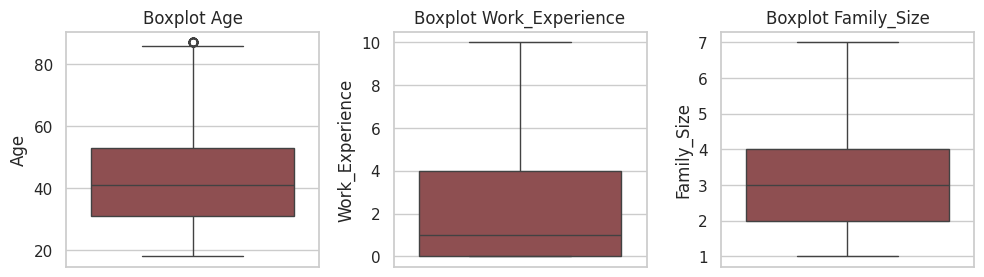

In [ ]:
# Box Plot Setelah Pembersihan Outlier
plt.figure(figsize=(10, 8))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=data[col], color=box_color)
    plt.title(f'Boxplot {col}')
    plt.tight_layout()
plt.show()

In [ ]:
data.describe()

,Age,Work_Experience,Family_Size
count,7720.000000,6911.000000,7399.000000
mean,43.331606,2.392128,2.798757
std,16.306127,3.047557,1.407572
min,18.000000,0.000000,1.000000
25%,31.000000,0.000000,2.000000
50%,41.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,87.000000,10.000000,7.000000


## **Imputasi Missing Value**

In [ ]:
# Numerik: isi dengan median
for col in num_cols:
    data[col] = data[col].fillna(data[col].median())

# Kategorikal: isi dengan modus
for col in cat_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

# Biner: isi dengan modus
for col in binary_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

## **Casting Tipe Data**

In [ ]:
data['Family_Size'] = data['Family_Size'].astype(int)
data['Work_Experience'] = data['Work_Experience'].astype(int)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7720 entries, 0 to 8067
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Gender           7720 non-null   object
 1   Ever_Married     7720 non-null   object
 2   Age              7720 non-null   int64 
 3   Graduated        7720 non-null   object
 4   Profession       7720 non-null   object
 5   Work_Experience  7720 non-null   int64 
 6   Spending_Score   7720 non-null   object
 7   Family_Size      7720 non-null   int64 
 8   Segmentation     7720 non-null   object
dtypes: int64(3), object(6)
memory usage: 603.1+ KB


## **Encoding**

### Label Encoding untuk Kolom Biner dan Segmentation

In [ ]:
le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender'])  # Female=0, Male=1
data['Ever_Married'] = le.fit_transform(data['Ever_Married'])  # No=0, Yes=1
data['Graduated'] = le.fit_transform(data['Graduated'])  # No=0, Yes=1
data['Segmentation'] = le.fit_transform(data['Segmentation'])  # A=0, B=1, C=2, D=3

In [ ]:
data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Segmentation
0,1,0,22,0,Healthcare,1,Low,4,3
1,0,1,38,1,Engineer,1,Average,3,0
2,0,1,67,1,Engineer,1,Low,1,1
3,1,1,67,1,Lawyer,0,High,2,1
4,0,1,40,1,Entertainment,1,High,6,0


### Ordinal Encoding untuk Spending Score

In [ ]:
spending_score_map = {'Low': 0, 'Average': 1, 'High': 2}
data['Spending_Score'] = data['Spending_Score'].map(spending_score_map)

data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Segmentation
0,1,0,22,0,Healthcare,1,0,4,3
1,0,1,38,1,Engineer,1,1,3,0
2,0,1,67,1,Engineer,1,0,1,1
3,1,1,67,1,Lawyer,0,2,2,1
4,0,1,40,1,Entertainment,1,2,6,0


### One-Hot Encoding untuk Fitur Profession

In [ ]:
data_encoded = pd.get_dummies(data, columns=["Profession"])

In [ ]:
data_encoded.head()

,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Segmentation,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing
0,1,0,22,0,1,0,4,3,False,False,False,False,False,True,False,False,False
1,0,1,38,1,1,1,3,0,False,False,True,False,False,False,False,False,False
2,0,1,67,1,1,0,1,1,False,False,True,False,False,False,False,False,False
3,1,1,67,1,0,2,2,1,False,False,False,False,False,False,False,True,False
4,0,1,40,1,1,2,6,0,False,False,False,True,False,False,False,False,False


## **Fix Skewness**

In [ ]:
for col in num_cols:
    data_encoded[col] = np.log1p(data_encoded[col])

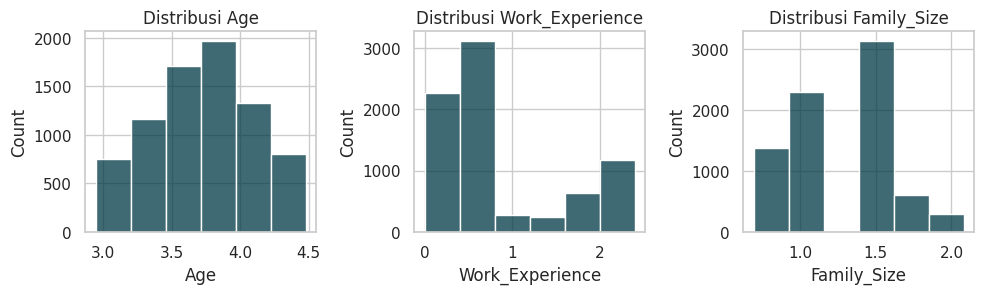

In [ ]:
hist_color = '#003844'
box_color = '#984447'

plt.figure(figsize=(10, 8))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i+1)
    sns.histplot(data_encoded[col], bins=6, color=hist_color, edgecolor='white', kde=False)
    plt.title(f'Distribusi {col}')
    plt.tight_layout()
plt.show()

## **Feature Scalling**

In [ ]:
scaler = StandardScaler()
scaled_cols = ["Age", "Work_Experience", "Family_Size", "Spending_Score"]
data_scaled = data_encoded.copy()
data_scaled[scaled_cols] = scaler.fit_transform(data_encoded[scaled_cols])

In [ ]:
data_scaled.head()

,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Segmentation,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing
0,1,0,-1.586412,0,-0.202423,-0.738594,0.926293,3,False,False,False,False,False,True,False,False,False
1,0,1,-0.163103,1,-0.202423,0.617398,0.314899,0,False,False,True,False,False,False,False,False,False
2,0,1,1.335348,1,-0.202423,-0.738594,-1.584262,1,False,False,True,False,False,False,False,False,False
3,1,1,1.335348,1,-1.100537,1.973391,-0.473324,1,False,False,False,False,False,False,False,True,False
4,0,1,-0.028309,1,-0.202423,1.973391,1.848197,0,False,False,False,True,False,False,False,False,False


## **Ambil Subset Dataset**

Sayangnya karena besarnya biaya komputasi untuk modeling hierarchical manual O(n3), kami harus mengurangi jumlah data, disini akan kami buat subset data yang stratified terhadap label Segmentation agar persebran kelas tetap merata dan memiliki karaktiristik yang sama dengan data awalnya, kita akan ambil subset berjumlah 1000 baris

In [ ]:
proportions = data_scaled["Segmentation"].value_counts(normalize=True)
samples_per_class = (proportions * 1000).round().astype(int)

subset = pd.concat([
        data_scaled[data_scaled["Segmentation"] == cls].sample(n=n, random_state=42)
        for cls, n in samples_per_class.items()])

In [ ]:
data_kecil = subset.sample(frac=1, random_state=42).reset_index(drop=True) # shuffle

In [ ]:
data_kecil

,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Segmentation,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing
0,1,1,2.030280,1,-0.202423,1.973391,-0.473324,2,False,False,False,False,True,False,False,False,False
1,0,1,1.254885,1,-0.202423,-0.738594,-1.584262,1,False,False,True,False,False,False,False,False,False
2,1,1,0.339806,0,-1.100537,0.617398,0.314899,0,False,False,False,True,False,False,False,False,False
3,0,0,-1.056216,1,-1.100537,-0.738594,0.926293,1,False,False,False,False,False,True,False,False,False
4,1,0,-0.094863,1,-0.202423,-0.738594,-1.584262,2,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,1,0,-0.613367,0,-1.100537,-0.738594,0.926293,3,True,False,False,False,False,False,False,False,False
997,0,0,-1.056216,0,-0.202423,-0.738594,0.314899,3,True,False,False,False,False,False,False,False,False
998,0,0,-0.163103,1,-0.202423,-0.738594,-1.584262,1,True,False,False,False,False,False,False,False,False
999,0,1,0.714014,1,-0.202423,-0.738594,-0.473324,2,True,False,False,False,False,False,False,False,False


In [ ]:
data_kecil["Segmentation"].value_counts()

,count
Segmentation,
3,279
2,247
0,242
1,233


In [ ]:
label = data_kecil["Segmentation"]

In [ ]:
data = data_kecil.drop(columns=("Segmentation"))

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Gender                    1001 non-null   int64  
 1   Ever_Married              1001 non-null   int64  
 2   Age                       1001 non-null   float64
 3   Graduated                 1001 non-null   int64  
 4   Work_Experience           1001 non-null   float64
 5   Spending_Score            1001 non-null   float64
 6   Family_Size               1001 non-null   float64
 7   Profession_Artist         1001 non-null   bool   
 8   Profession_Doctor         1001 non-null   bool   
 9   Profession_Engineer       1001 non-null   bool   
 10  Profession_Entertainment  1001 non-null   bool   
 11  Profession_Executive      1001 non-null   bool   
 12  Profession_Healthcare     1001 non-null   bool   
 13  Profession_Homemaker      1001 non-null   bool   
 14  Professi

In [ ]:
# # Simpan Preprocessed dalam bentuk CSV
# data.to_csv('preprocessed_dataset.csv', index=False)

# **Modeling**

## **Menentukan Jumlah Cluster Optimal dengan Elbow Method**

Referensi : https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

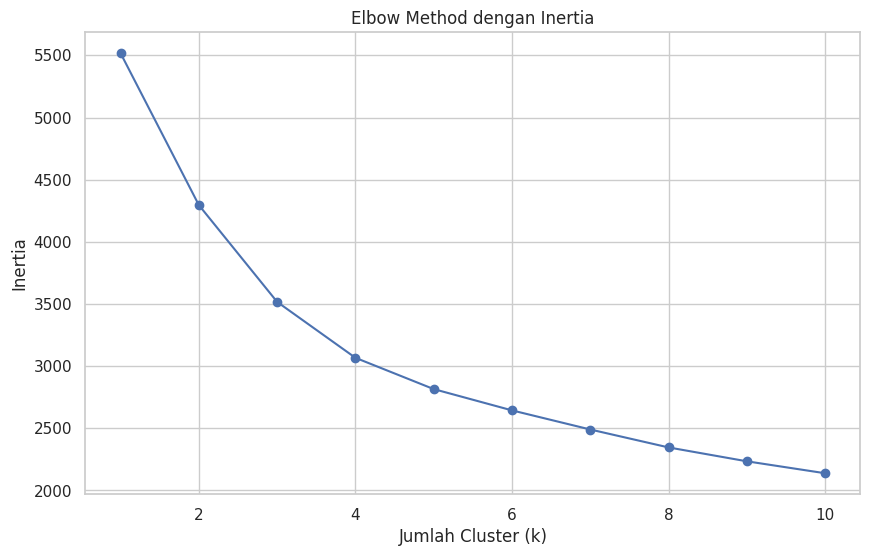

In [ ]:
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method dengan Inertia')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.show()

Bisa dilihat elbow terdapat di k = 4 sesuai dengan label segmentasi yang di berikan oleh team marketing sebelumnya, setelah k=4 inertia mulai konvergen

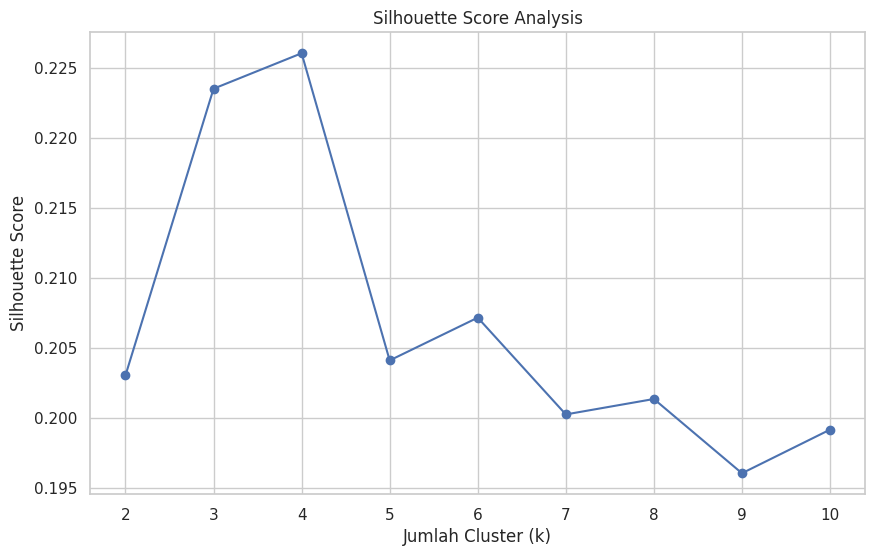

In [ ]:
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(data)
    score = silhouette_score(data, kmeans.labels_)
    silhouette_scores.append(score)
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score Analysis')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette Score')
plt.show()

Sesuai dengan elbow method k=4 memiliki nilai tertinggi untuk silhouette nya

## **Perhitungan Jarak**

In [ ]:
def euclidean(data1, data2):
  jarak=np.square(data1-data2)
  jarak=np.sum(jarak)
  return np.sqrt(jarak)

In [ ]:
def manhattan(data1, data2):
  jarak=np.abs(data1-data2)
  jarak=np.sum(jarak)
  return jarak

## **K-Means**

### K-Means library

In [ ]:
kmeans_library = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_library_labels = kmeans_library.fit_predict(data)

### K-Means Manual

In [ ]:
def kmeans_manual(data_input, k, iter_max=200, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    n_data = data_input.shape[0]
    n_fitur = data_input.shape[1]
    iterasi = 1

    cluster = np.random.randint(0, k, size=n_data) # memberi cluster acak sebagai awalan
    centroid = np.zeros((k, n_fitur))
    cluster_tidak_berubah = False

    while not cluster_tidak_berubah and iterasi < iter_max:
        jarak = np.zeros((n_data, k))

        for i in range(k):
            anggota = data_input.iloc[np.where(cluster == i)[0]] # ambil data anggota klaster ke-i
            if not anggota.empty:
                centroid[i, :] = anggota.mean().values # (1) Hitung centroid sebagai rata-rata anggota
            else:
                centroid[i, :] = data_input.sample(n=1, random_state=random_state).values # Jika tidak ada anggota, sampling satu data acak sebagai centroid

        for i in range(n_data): # Hitung jarak dari setiap data ke setiap centroid
            for j in range(k):
                jarak[i][j] = euclidean(data_input.iloc[i], centroid[j]) # (2) Hitung jarak Euclidean

        cluster_baru = [np.argmin(jarak[i]) for i in range(n_data)] # Tentukan klaster baru berdasarkan centroid terdekat
        cluster_tidak_berubah = np.array_equal(cluster_baru, cluster) # Periksa apakah klaster sudah tidak berubah (konvergen)
        cluster = np.array(copy.deepcopy(cluster_baru)) # Perbarui klaster untuk iterasi berikutnya
        iterasi += 1 # naikkan iterasi

    return cluster, centroid, jarak

Fungsi kmeans_manual merupakan implementasi algoritma K-Means yang mengelompokkan data menjadi k klaster berdasarkan jarak Euclidean. Jika parameter random_state diberikan, maka fungsi menetapkan seed untuk memastikan hasil acak yang konsisten. Setiap data diberi label klaster secara acak, dan centroid diinisialisasi sebagai array kosong.

Proses inti berlangsung dalam loop yang berjalan hingga klaster tidak berubah lagi atau jumlah iterasi mencapai iter_max. Pada setiap iterasi, centroid dihitung ulang sebagai rata-rata dari data yang termasuk dalam masing-masing klaster. Jika ada klaster kosong, centroid-nya diisi dengan titik data acak untuk menghindari error.

Selanjutnya, fungsi menghitung jarak antara setiap titik data dan seluruh centroid menggunakan fungsi euclidean, yang mengembalikan akar kuadrat dari jumlah selisih kuadrat antar fitur. Berdasarkan matriks jarak ini, setiap data diberi klaster baru dengan memilih centroid terdekat. Iterasi berlanjut jika terjadi perubahan klaster, dan berhenti jika tidak ada perubahan.

Akhirnya, fungsi mengembalikan tiga hal: label klaster akhir (cluster), posisi centroid (centroid), dan matriks jarak (jarak) antara setiap titik data dan centroid. Fungsi ini dapat digunakan untuk memahami cara kerja K-Means tanpa menggunakan pustaka eksternal seperti scikit-learn.

In [ ]:
kmeans_manual_labels, centroids_manual, jarak_manual = kmeans_manual(data, 4, random_state=42)

membuat model dengan data `'data'` dan menetapkan jumlah cluster sebanyak `4` sesuai hasil penentuan cluster terbaik

In [ ]:
kmeans_manual_labels

array([0, 3, 2, ..., 3, 3, 1])

In [ ]:
centroids_manual

array([[ 0.61146497,  1.        ,  0.870172  ,  0.62420382, -0.18400576,
         1.95611698,  0.07155252,  0.17834395,  0.01910828,  0.06369427,
         0.03184713,  0.36305732,  0.00636943,  0.00636943,  0.29299363,
         0.03821656],
       [ 0.52788104,  0.14126394, -1.06890438,  0.30483271,  0.08115056,
        -0.67306317,  0.75375822,  0.08550186,  0.133829  ,  0.07063197,
         0.09665428,  0.01858736,  0.49070632,  0.04460967,  0.00371747,
         0.05576208],
       [ 0.64485981,  0.96573209,  0.49743661,  0.7788162 , -0.25829377,
         0.24988617,  0.23066834,  0.53582555,  0.07788162,  0.07165109,
         0.14018692,  0.04984424,  0.02492212,  0.01869159,  0.06542056,
         0.01557632],
       [ 0.46456693,  0.44094488,  0.15769162,  0.73228346,  0.13003655,
        -0.7279173 , -1.28247199,  0.3976378 ,  0.1023622 ,  0.09055118,
         0.16535433,  0.00787402,  0.07086614,  0.03937008,  0.09055118,
         0.03543307]])

In [ ]:
jarak_manual

array([[1.570314  , 4.57023145, 2.68724281, 3.6666444 ],
       [3.43448682, 3.68713018, 2.54882203, 1.74491082],
       [2.16934073, 2.71743961, 1.62966211, 2.81672337],
       ...,
       [3.67233617, 2.87544703, 2.52233879, 1.10068416],
       [2.99965819, 2.71723755, 1.49764959, 1.44908395],
       [3.87926676, 1.08626245, 2.63102407, 2.93581005]])

## **Hierarchical Clustering**

### Hierarchical Library

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Single Linkage Euclidean
linked_single_eu = linkage(data, method='single', metric='euclidean')

# Single Linkage Manhattan
linked_single_mh = linkage(data, method='single', metric='cityblock')

# Complete Linkage Euclidean
linked_complete_eu = linkage(data, method='complete', metric='euclidean')

# Complete Linkage Manhattan
linked_complete_mh = linkage(data, method='complete', metric='cityblock')

- `linked_single_eu` = linkage(data, method='single', metric='euclidean')
→ Mengelompokkan data dengan `single linkage`, yaitu menggabungkan dua klaster berdasarkan jarak terpendek antar titik dari kedua klaster, menggunakan `jarak Euclidean` sebagai pengukurnya.

- `linked_single_mh` = linkage(data, method='single', metric='cityblock')
→ Sama seperti sebelumnya menggunakan `single linkage`, tapi jarak antar titik diukur menggunakan `jarak Manhattan` (cityblock), yaitu jumlah selisih absolut antar dimensi.

- `linked_complete_eu` = linkage(data, method='complete', metric='euclidean')
→ Mengelompokkan data dengan `complete linkage`, yaitu menggabungkan dua klaster berdasarkan jarak terjauh antar titik dari kedua klaster, dengan `jarak Euclidean`.

- `linked_complete_mh` = linkage(data, method='complete', metric='cityblock')
→ Sama seperti sebelumnya menggunakan `complete linkage`, tapi menggunakan `jarak Manhattan` untuk menghitung jarak antar titik.

output dari kode ini adalah struktur data yang berisi informasi tentang bagaimana data akan digabungkan secara bertahap menjadi klaster, yaitu hasil proses penggabungan klaster secara hierarkis. Dendogram bisa dibuat melalui adta ini

In [ ]:
from scipy.cluster.hierarchy import fcluster

# Single Linkage Euclidean
single_eu_labels = fcluster(linked_single_eu, 4, criterion='maxclust')

# Single Linkage Manhattan
single_mh_labels = fcluster(linked_single_mh, 4, criterion='maxclust')

# Complete Linkage Euclidean
complete_eu_labels = fcluster(linked_complete_eu, 4, criterion='maxclust')

# Complete Linkage Manhattan
complete_mh_labels = fcluster(linked_complete_mh, 4, criterion='maxclust')

- single_eu_labels = fcluster(linked_single_eu, 4, criterion='maxclust')
→ Menghasilkan label klaster dengan memotong dendrogram hasil `single linkage menggunakan jarak Euclidean` sehingga terbentuk 4 klaster.

- single_mh_labels = fcluster(linked_single_mh, 4, criterion='maxclust')
→ Menghasilkan label klaster dengan memotong dendrogram hasil `single linkage menggunakan jarak Manhattan` untuk membentuk 4 klaster.

- complete_eu_labels = fcluster(linked_complete_eu, 4, criterion='maxclust')
→ Menghasilkan label klaster dari dendrogram hasil `complete linkage dengan jarak Euclidean`, dipotong untuk membentuk 4 klaster.

- complete_mh_labels = fcluster(linked_complete_mh, 4, criterion='maxclust')
→ Menghasilkan label klaster dari dendrogram hasil `complete linkage dengan jarak Manhattan`, dipotong untuk membentuk 4 klaster.

`linkage` membuat model cluster hirarkis lengkap berupa dendrogram yang menggambarkan penggabungan data secara bertahap tanpa menentukan jumlah klaster akhir, sedangkan `fcluster` menggunakan hasil dendrogram tersebut untuk memotong dan membagi data menjadi klaster datar sesuai jumlah klaster yang  ditentukan (dalam kasus ini 4 klaster). Jadi, linkage membangun struktur klaster secara menyeluruh, dan fcluster memilih pembagian akhir berdasarkan kriteria yang diinginkan tanpa membuat model baru.

### **Hierarchical Manual**

In [ ]:
def buat_matrix_jarak(data, metric='euclidean'):
    data = np.array(data)
    n_samples = data.shape[0]
    distance_matrix = np.zeros((n_samples, n_samples))

    # Pilih fungsi jarak
    if metric == 'euclidean':
        distance_func = euclidean
    elif metric == 'manhattan':
        distance_func = manhattan
    else:
        raise ValueError("Metric harus 'euclidean' atau 'manhattan'")

    # Hitung jarak untuk setiap pasangan titik
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            dist = distance_func(data[i], data[j])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist  # Matriks simetris

    return distance_matrix

Fungsi ini digunakan untuk menghitung matriks jarak antar semua pasangan titik dalam dataset. Data terlebih dahulu diubah ke array NumPy dan disiapkan dalam bentuk matriks kosong berukuran n x n. Kemudian, fungsi memilih metode pengukuran jarak yang akan digunakan, yaitu Euclidean (jarak lurus) atau Manhattan (jumlah selisih absolut antar dimensi). Setelah itu, fungsi menghitung jarak untuk setiap pasangan titik unik (i, j), menyimpan hasilnya dalam matriks jarak, dan menjamin bahwa matriks tersebut bersifat simetris. Matriks inilah yang nantinya digunakan sebagai dasar dalam penggabungan klaster.

In [ ]:
def jarak_single_linkage(cluster1_indices, cluster2_indices, distance_matrix):
    min_distance = float('inf')

    # Cari jarak minimum antar semua pasangan titik
    for i in cluster1_indices:
        for j in cluster2_indices:
            distance = distance_matrix[i, j]
            if distance < min_distance:
                min_distance = distance

    return min_distance

Fungsi ini menghitung jarak antar dua klaster berdasarkan pendekatan single linkage, yaitu dengan mencari jarak terpendek antara satu titik dari klaster pertama dan satu titik dari klaster kedua. Fungsi ini mengevaluasi semua kombinasi titik dari dua klaster yang diberikan dan menyimpan nilai minimum dari semua jarak tersebut. Hasilnya adalah satu nilai jarak minimum yang merepresentasikan kedekatan antar dua klaster menurut single linkage.

In [ ]:
def jarak_complete_linkage(cluster1_indices, cluster2_indices, distance_matrix):
    max_distance = 0

    # Cari jarak maksimum antar semua pasangan titik
    for i in cluster1_indices:
        for j in cluster2_indices:
            distance = distance_matrix[i, j]
            if distance > max_distance:
                max_distance = distance

    return max_distance

Berbeda dengan single linkage, fungsi ini menerapkan metode complete linkage untuk menghitung jarak antar dua klaster. Ia mencari jarak maksimum dari semua pasangan titik yang mungkin antara dua klaster. Dengan kata lain, fungsi ini menganggap dua klaster “jauh” bila ada dua titik yang sangat berjauhan. Nilai jarak maksimum ini digunakan sebagai dasar penggabungan klaster dalam metode complete linkage.

In [ ]:
def hitung_jarak_cluster(cluster1_indices, cluster2_indices, distance_matrix, linkage='single'):
    if linkage == 'single':
        return jarak_single_linkage(cluster1_indices, cluster2_indices, distance_matrix)
    elif linkage == 'complete':
        return jarak_complete_linkage(cluster1_indices, cluster2_indices, distance_matrix)
    else:
        raise ValueError("Linkage harus 'single' atau 'complete'")

Fungsi ini bertugas memilih metode linkage yang akan digunakan untuk menghitung jarak antar dua klaster. Jika parameter linkage bernilai `single`, maka fungsi memanggil jarak_single_linkage, dan jika `complete`, maka dipanggil jarak_complete_linkage. Jika metode linkage yang diberikan tidak dikenali, maka fungsi akan menghasilkan error. Fungsi ini membuat proses pemanggilan jarak antar klaster menjadi fleksibel tergantung metode linkage yang dipilih.

In [ ]:
def cari_cluster_terdekat(clusters, distance_matrix, linkage='single'):
    min_distance = float('inf')
    closest_pair = (-1, -1)

    # Bandingkan semua pasangan cluster
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            distance = hitung_jarak_cluster(
                clusters[i], clusters[j], distance_matrix, linkage
            )

            if distance < min_distance:
                min_distance = distance
                closest_pair = (i, j)

    return closest_pair[0], closest_pair[1], min_distance

Fungsi ini mencari dua klaster yang paling dekat satu sama lain dari daftar klaster yang ada, berdasarkan metode linkage yang dipilih. Dengan membandingkan semua pasangan klaster (kombinasi dua klaster dari seluruh daftar), fungsi ini menghitung jarak antar klaster menggunakan hitung_jarak_cluster, lalu menyimpan pasangan dengan jarak terkecil. Hasil akhirnya adalah indeks dua klaster terdekat dan nilai jarak minimum di antara mereka. Fungsi ini menjadi inti dari proses pemilihan penggabungan klaster berikutnya dalam algoritma hierarkis.

In [ ]:
def agglomerative_clustering(data, metric='euclidean', linkage='single'):
    data = np.array(data)
    n_samples = data.shape[0]

    # Langkah 1: Buat matriks jarak antar titik data
    distance_matrix = buat_matrix_jarak(data, metric)

    # Langkah 2: Inisialisasi - setiap titik dianggap sebagai cluster sendiri
    # Sekarang clusters akan menyimpan list dari cluster, dan kita juga perlu
    # menyimpan ID permanen untuk setiap cluster (original index atau index merge)
    clusters = [[i] for i in range(n_samples)]
    # Initial IDs are the indices of the data points
    current_cluster_ids = list(range(n_samples))

    # List untuk menyimpan linkage matrix
    linkage_matrix = []

    # Langkah 3: Proses penggabungan cluster hingga tersisa satu cluster
    # Melakukan n_samples - 1 penggabungan
    for _ in range(n_samples - 1):

        # Cari dua cluster terdekat berdasarkan linkage dan metrik jarak
        # cari_cluster_terdekat sekarang bekerja dengan list of lists (clusters)
        # dan mengembalikan index di list 'clusters'
        i, j, min_dist = cari_cluster_terdekat(clusters, distance_matrix, linkage)

        # Ambil ID asli dari cluster yang akan digabung
        id1 = current_cluster_ids[i]
        id2 = current_cluster_ids[j]

        # Gabungkan kedua cluster (list of point indices)
        new_cluster_points = clusters[i] + clusters[j]

        # Hapus cluster yang sudah digabung dari daftar dan ID mereka
        # Hapus index j dulu agar index i tidak berubah
        del clusters[j]
        del clusters[i]
        del current_cluster_ids[j]
        del current_cluster_ids[i]

        # Tambahkan cluster hasil gabungan ke daftar cluster baru
        clusters.append(new_cluster_points)
        # ID untuk cluster baru adalah n_samples + (jumlah merge yang sudah dilakukan)
        new_cluster_id = n_samples + len(linkage_matrix)
        current_cluster_ids.append(new_cluster_id)

        # Tambahkan informasi penggabungan ke linkage matrix:
        # [id_cluster1, id_cluster2, jarak_penggabungan, jumlah_total_anggota_cluster]
        # Urutkan ID cluster agar sesuai format SciPy (ID lebih kecil di kiri)
        if id1 > id2:
            id1, id2 = id2, id1

        linkage_matrix.append([
            id1,
            id2,
            min_dist,
            len(new_cluster_points)
        ])

    # Kembalikan linkage matrix dalam bentuk array numpy
    return np.array(linkage_matrix)

Fungsi ini merupakan implementasi lengkap dari algoritma Agglomerative Hierarchical Clustering secara manual. Langkah pertama adalah menghitung matriks jarak antar titik menggunakan metrik Euclidean atau Manhattan. Kemudian, setiap titik diasumsikan sebagai klaster tunggal dan disimpan dalam daftar. Selanjutnya, dilakukan proses penggabungan klaster secara bertahap: dua klaster terdekat dipilih dan digabung menjadi satu, lalu dicatat dalam linkage matrix dengan format [id_klaster1, id_klaster2, jarak, jumlah_anggota]. ID klaster juga dikelola agar sesuai dengan format standar SciPy. Proses ini diulang hingga semua titik tergabung menjadi satu klaster besar. Hasil akhir dari fungsi ini adalah linkage matrix dalam bentuk array NumPy, yang bisa digunakan untuk visualisasi dendrogram atau pemotongan klaster.

In [ ]:
# Hierarchical Clustering Manual Single Linkage Euclidean
matrix_single_eu = agglomerative_clustering(data, metric='euclidean', linkage='single')

# Hierarchical Clustering Manual Single Linkage Manhattan
matrix_single_mh = agglomerative_clustering(data, metric='manhattan', linkage='single')

# Hierarchical Clustering Manual Complete Linkage Euclidean
matrix_complete_eu = agglomerative_clustering(data, metric='euclidean', linkage='complete')

# Hierarchical Clustering Manual Complete Linkage Manhattan
matrix_complete_mh= agglomerative_clustering(data, metric='manhattan', linkage='complete')

- matrix_single_eu = agglomerative_clustering(data, metric='euclidean', linkage='single')
→ Mengelompokkan data secara manual dengan metode hierarchical clustering menggunakan `single linkage`, yaitu menggabungkan dua klaster berdasarkan jarak terpendek antar titik dari kedua klaster, dan menghitung jaraknya menggunakan metrik `Euclidean` (jarak lurus antar titik).

- matrix_single_mh = agglomerative_clustering(data, metric='manhattan', linkage='single')
→ Sama seperti sebelumnya menggunakan `single linkage`, namun jarak antar titik dihitung dengan jarak `Manhattan (cityblock)`, yaitu penjumlahan selisih absolut antar dimensi.

- matrix_complete_eu = agglomerative_clustering(data, metric='euclidean', linkage='complete')
→ Mengelompokkan data secara manual dengan metode `complete linkage`, yaitu menggabungkan dua klaster berdasarkan jarak terjauh antar titik dari kedua klaster, dengan pengukuran jarak menggunakan metrik `Euclidean`.

- matrix_complete_mh = agglomerative_clustering(data, metric='manhattan', linkage='complete')
→ Sama seperti sebelumnya menggunakan `complete linkage`, namun menghitung jarak antar titik dengan metrik `Manhattan` (jumlah selisih absolut antar dimensi).

Output dari keempat baris kode ini adalah struktur data linkage matrix buatan sendiri, yang berisi informasi penggabungan klaster secara bertahap. Struktur ini mirip dengan hasil dari scipy.linkage() dan dapat digunakan untuk membangun dendrogram, yang menggambarkan proses pengelompokan hierarkis.

In [ ]:
from scipy.cluster.hierarchy import fcluster

# Single Linkage Euclidean
label_single_eu = fcluster(matrix_single_eu, 4, criterion='maxclust')

# Single Linkage Manhattan
label_single_mh = fcluster(matrix_complete_mh, 4, criterion='maxclust')

# Complete Linkage Euclidean
label_complete_eu = fcluster(matrix_complete_eu, 4, criterion='maxclust')

# Complete Linkage Manhattan
label_complete_mh = fcluster(matrix_complete_mh, 4, criterion='maxclust')

- label_single_eu = fcluster(matrix_single_eu, 4, criterion='maxclust')
→ Menghasilkan label klaster dari hasil hierarchical clustering manual `(single linkage dengan jarak Euclidean)`, dengan memotong dendrogram pada jumlah maksimum 4 klaster. Artinya, data dikelompokkan menjadi 4 klaster berdasarkan struktur matrix_single_eu.

- label_single_mh = fcluster(matrix_complete_mh, 4, criterion='maxclust')
→ Sama seperti sebelumnya, namun label klaster diambil dari hasil `complete linkage dengan jarak Manhattan` (matrix_complete_mh), dan jumlah klaster yang diinginkan tetap 4.

- label_complete_eu = fcluster(matrix_complete_eu, 4, criterion='maxclust')
→ Menghasilkan label klaster dari hasil `complete linkage dengan metrik Euclidean`, yaitu mengelompokkan data menjadi 4 klaster berdasarkan struktur matrix_complete_eu.

- label_complete_mh = fcluster(matrix_complete_mh, 4, criterion='maxclust')
→ Sama seperti sebelumnya, tapi label diambil dari hasil hierarchical clustering `complete linkage dengan metrik Manhattan` (matrix_complete_mh), dan dibagi menjadi 4 klaster.

Keempat baris kode ini bertugas mengubah hasil hierarchical clustering (yang berupa linkage matrix) menjadi label klaster eksplisit untuk masing-masing data, berdasarkan jumlah klaster yang diinginkan.

# **Evaluasi**

Evaluasi clustering yang digunakan dalam analisis ini meliputi **Silhouette Score**, **Davies-Bouldin Index (DBI)**, **Calinski-Harabasz (CH) Score**, **Rand Index**, dan **Purity**.  
- `**Silhouette Score**` mengukur seberapa mirip suatu data dengan klaster sendiri dibandingkan dengan klaster lain; nilai mendekati 1 menunjukkan klaster yang baik.  
- `**Davies-Bouldin Index**` mengukur rata-rata kemiripan antar klaster; nilai yang lebih rendah menunjukkan pemisahan klaster yang lebih baik.  
- `**Calinski-Harabasz Score**` menilai rasio dispersi antar-klaster dengan intra-klaster; nilai yang lebih tinggi menunjukkan struktur klaster yang lebih baik.  
- `**Rand Index**` membandingkan kesesuaian antara klaster hasil algoritma dan label sebenarnya; nilai 1 menunjukkan kesesuaian sempurna.  
- `**Purity**` menghitung proporsi data terbanyak dari satu kelas dalam setiap klaster; semakin mendekati 1, semakin sesuai klaster dengan label aslinya.
- Untuk `**Hierarchical Clustering**`, juga digunakan visualisasi berupa `**dendogram**`, yaitu diagram pohon yang menunjukkan proses penggabungan klaster secara bertahap

## **Fungsi Untuk Evaluasi**

In [ ]:
def purity_score(y_true, y_pred) :
  # Compute contingency matrix
  contingency_matrix = np.zeros ((np.max(y_pred) +1, np.max(y_true)+1))
  for i in range (len(y_true) ):
    contingency_matrix[y_pred[i]] [y_true[i]] += 1

  return np.sum(np.amax (contingency_matrix, axis=1) ) / np.sum(contingency_matrix)

Fungsi `purity_score(y_true, y_pred)` digunakan untuk menghitung **nilai purity**, yaitu ukuran seberapa "murni" hasil clustering dibandingkan dengan label asli (ground truth). Purity menggambarkan seberapa banyak data dalam satu klaster yang berasal dari kelas yang sama.

Rumus Purity:

$$
Purity(C, W) = \frac{1}{N} \sum_{i=1}^{k} \max_j \left| c_i \cap w_j \right|
$$

Keterangan:

- $N$ : Jumlah total data  
  → `N = len(y_true)` (jumlah elemen dalam label asli)

- $k$ : Jumlah klaster hasil prediksi  
  → `k = np.max(y_pred) + 1` (jumlah label unik dalam prediksi, diasumsikan label mulai dari 0)

- $c_i$ : Himpunan data pada klaster ke-$i$  
  → Data dengan `y_pred == i`

- $w_j$ : Himpunan data dari kelas ground truth ke-$j$  
  → Data dengan `y_true == j`

- $|c_i \cap w_j|$ : Banyaknya data yang ada di klaster $i$ dan juga termasuk dalam kelas $j$  
  → `contingency_matrix[i][j]` (nilai frekuensi untuk pasangan klaster $i$ dan kelas $j$)

- $\max_j |c_i \cap w_j|$ : Jumlah anggota terbanyak dari satu kelas (kelas mayoritas) dalam klaster $i$  
  → `np.amax(contingency_matrix, axis=1)[i]`


Cara Kerja Kode:
1. Membuat *contingency matrix* berukuran `(jumlah_klaster × jumlah_kelas)` yang menyimpan frekuensi data yang ada di masing-masing kombinasi `klaster i` dan `kelas j`.
2. Untuk setiap baris (klaster), diambil nilai maksimum, yaitu jumlah anggota kelas mayoritas dalam klaster tersebut.
3. Semua nilai maksimum dijumlahkan, lalu dibagi dengan total jumlah data ($N$) untuk mendapatkan nilai purity.

Nilai purity berada dalam rentang 0 hingga 1, di mana nilai yang lebih tinggi menunjukkan bahwa hasil klastering semakin sesuai dengan label kelas sebenarnya.

## **Persiapan Data**

In [ ]:
# Persiapan data untuk Evaluasi
X = data
y = np.array(label)

## **KMeans**

### Kmeans Library

In [ ]:
sil_score = silhouette_score (X, kmeans_library_labels)
db_index = davies_bouldin_score (X, kmeans_library_labels)
ch_score = calinski_harabasz_score (X, kmeans_library_labels)
rand_index = adjusted_rand_score (y, kmeans_library_labels)

print (f"Silhouette Score: {sil_score}")
print (f"Davies-Bouldin Index: {db_index}")
print (f"Calinski-Harabasz Index: {ch_score}")
print (f"Rand score: {rand_index} ")

purity = purity_score(y, kmeans_library_labels)
print("Purity Score : ", purity)

Silhouette Score: 0.22602755268825062
Davies-Bouldin Index: 1.458551760465387
Calinski-Harabasz Index: 265.5022395214006
Rand score: 0.07712440811608451 
Purity Score :  0.4095904095904096


### Kmeans Manual

In [ ]:
sil_score = silhouette_score (X, kmeans_manual_labels)
db_index = davies_bouldin_score (X, kmeans_manual_labels)
ch_score = calinski_harabasz_score (X, kmeans_manual_labels)
rand_index = adjusted_rand_score (y, kmeans_manual_labels)

print (f"Silhouette Score: {sil_score}")
print (f"Davies-Bouldin Index: {db_index}")
print (f"Calinski-Harabasz Index: {ch_score}")
print (f"Rand score: {rand_index} ")

def purity_score(y_true, y_pred) :
  # Compute contingency matrix
  contingency_matrix = np.zeros((np.max(y_pred) +1, np.max(y_true)+1))
  for i in range (len(y_true) ):
    contingency_matrix[y_pred[i]] [y_true[i]] += 1

  return np.sum(np.amax(contingency_matrix, axis=1)) / np.sum(contingency_matrix)

purity = purity_score(y, kmeans_manual_labels)
print("Purity Score : ", purity)

Silhouette Score: 0.18806805282969472
Davies-Bouldin Index: 1.7667794541462343
Calinski-Harabasz Index: 234.11933349229778
Rand score: 0.09935716149242034 
Purity Score :  0.42957042957042957


Berdasarkan hasil evaluasi, model `KMeans dari library sedikit lebih baik dibandingkan dengan KMeans manual`. Hal ini terlihat dari nilai Silhouette Score dan Calinski-Harabasz Index yang sedikit lebih tinggi, serta Davies-Bouldin Index yang sedikit lebih rendah, menunjukkan bahwa struktur klaster yang dihasilkan lebih kompak dan terpisah dengan lebih baik. Selain itu, nilai Rand Score dan Purity juga sedikit lebih tinggi pada versi library, mengindikasikan hasil klaster yang lebih konsisten dengan label sebenarnya.

### Beberapa Hal yang Mungkin/Dapat Menjadi Alasan Mengapa K-Means Library Lebih Baik daripada K-Means Manual pada Data Online Retail

- **Optimisasi numerik yang lebih baik**: Library seperti `scikit-learn` menggunakan implementasi yang telah dioptimalkan dengan algoritma seperti *k-means++ initialization* dan operasi vektorisasi penuh, sehingga proses konvergensi lebih efisien dan hasil klaster lebih stabil.

- **Inisialisasi centroid yang lebih cerdas**: KMeans dari library menggunakan strategi inisialisasi *k-means++* yang memilih centroid awal secara strategis untuk memaksimalkan jarak antar centroid. Ini mengurangi risiko hasil buruk akibat inisialisasi acak seperti pada KMeans manual.

- **Vektorisasi dan pengelolaan numerik yang lebih akurat**: Perhitungan jarak dan centroid dilakukan dengan precision tinggi dan lebih cepat, serta lebih tahan terhadap noise dan outlier dibanding implementasi manual yang lebih sederhana.

- **Evaluasi iteratif yang lebih matang**: Implementasi library sudah memperhitungkan toleransi konvergensi, maksimisasi efisiensi memori, dan penanganan kondisi ekstrem (misalnya centroid tanpa anggota) dengan cara yang lebih robust dibanding pendekatan `from scratch`.

Secara keseluruhan, meskipun implementasi manual dapat digunakan untuk pembelajaran konsep dasar, penggunaan library memberikan hasil yang lebih dapat diandalkan dan efisien dalam praktik nyata.


## **Hierarchical Clustering**

### Hierarchical Library

In [ ]:
# Score HC Single Euclidean Library

sil_score = silhouette_score(X, single_eu_labels)
db_index = davies_bouldin_score(X, single_eu_labels)
ch_score = calinski_harabasz_score(X, single_eu_labels)
rand_index = adjusted_rand_score(y, single_eu_labels)

print(f"Silhouette Score: {sil_score}")
print(f"Davies-Bouldin Index: {db_index}")
print(f"Calinski-Harabasz Index: {ch_score}")
print(f"Rand score: {rand_index}")

purity = purity_score(y, single_eu_labels)
print("Purity Score:", purity)

Silhouette Score: -0.006176820231283161
Davies-Bouldin Index: 0.8093123386318782
Calinski-Harabasz Index: 1.476396777955852
Rand score: 0.00016380585082773693
Purity Score: 0.2817182817182817


In [ ]:
# Score HC Single Manhattan Library

sil_score = silhouette_score(X, single_mh_labels)
db_index = davies_bouldin_score(X, single_mh_labels)
ch_score = calinski_harabasz_score(X, single_mh_labels)
rand_index = adjusted_rand_score(y, single_mh_labels)

print(f"Silhouette Score: {sil_score}")
print(f"Davies-Bouldin Index: {db_index}")
print(f"Calinski-Harabasz Index: {ch_score}")
print(f"Rand score: {rand_index}")

purity = purity_score(y, single_mh_labels)
print("Purity Score:", purity)

Silhouette Score: -0.006176820231283161
Davies-Bouldin Index: 0.8093123386318782
Calinski-Harabasz Index: 1.476396777955852
Rand score: 0.00016380585082773693
Purity Score: 0.2817182817182817


In [ ]:
# Score HC Complete Euclidean Library

sil_score = silhouette_score(X, complete_eu_labels)
db_index = davies_bouldin_score(X, complete_eu_labels)
ch_score = calinski_harabasz_score(X, complete_eu_labels)
rand_index = adjusted_rand_score(y, complete_eu_labels)

print(f"Silhouette Score: {sil_score}")
print(f"Davies-Bouldin Index: {db_index}")
print(f"Calinski-Harabasz Index: {ch_score}")
print(f"Rand score: {rand_index}")

purity = purity_score(y, complete_eu_labels)
print("Purity Score:", purity)

Silhouette Score: 0.13555890801012369
Davies-Bouldin Index: 1.8275742032223552
Calinski-Harabasz Index: 160.9079075691122
Rand score: 0.0500930874314201
Purity Score: 0.3836163836163836


In [ ]:
# Score HC Complete Manhattan Library

sil_score = silhouette_score(X, complete_mh_labels)
db_index = davies_bouldin_score(X, complete_mh_labels)
ch_score = calinski_harabasz_score(X, complete_mh_labels)
rand_index = adjusted_rand_score(y, complete_mh_labels)

print(f"Silhouette Score: {sil_score}")
print(f"Davies-Bouldin Index: {db_index}")
print(f"Calinski-Harabasz Index: {ch_score}")
print(f"Rand score: {rand_index}")

purity = purity_score(y, complete_mh_labels)
print("Purity Score:", purity)

Silhouette Score: 0.144897681345721
Davies-Bouldin Index: 2.137103975822582
Calinski-Harabasz Index: 190.73933121891233
Rand score: 0.080769364817105
Purity Score: 0.4155844155844156


| **Metode**                    | **Silhouette Score** | **Davies-Bouldin Index** | **Calinski-Harabasz Index** | **Rand Score** | **Purity Score** |
| ----------------------------- | -------------------- | ------------------------ | --------------------------- | -------------- | ---------------- |
| HC Single Euclidean Library   | -0.00298             | 0.75418                  | 1.74158                     | -0.000077      | 0.28072          |
| HC Single Manhattan Library   | 0.04493              | 0.76455                  | 1.65547                     | -0.000045      | 0.28072          |
| HC Complete Euclidean Library | 0.12003              | 1.92545                  | 169.61902                   | 0.09090        | 0.41558          |
| HC Complete Manhattan Library | 0.12776              | 2.10939                  | 173.70221                   | 0.06037        | 0.38561          |


Analisis Singkat:
- Silhouette Score tertinggi diperoleh oleh HC Complete Manhattan, menunjukkan pemisahan cluster yang relatif lebih baik dibanding metode lain.

- Davies-Bouldin Index (DBI) terendah dimiliki oleh HC Single Euclidean, namun skor lainnya rendah karena Silhouette-nya negatif.

- Calinski-Harabasz Index (CHI) tertinggi ada pada HC Complete Manhattan, mengindikasikan pemisahan antar cluster cukup optimal.

- Rand Score dan Purity Score tertinggi diperoleh oleh HC Complete Euclidean.

Kesimpulan:

`HC Complete Euclidean Library adalah model terbaik` secara keseluruhan karena memiliki kombinasi Rand Score dan Purity Score tertinggi, serta nilai Silhouette dan CHI yang cukup baik, meskipun DBI-nya sedikit lebih tinggi dibanding metode lain. Ini menunjukkan model tersebut paling mendekati struktur label sebenarnya dan membentuk cluster yang cukup baik.

#### Dendogram

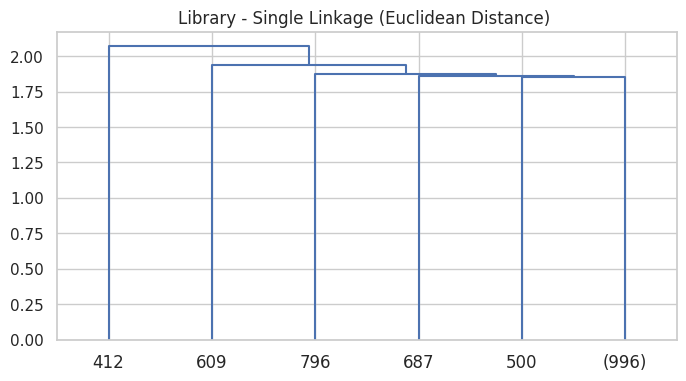

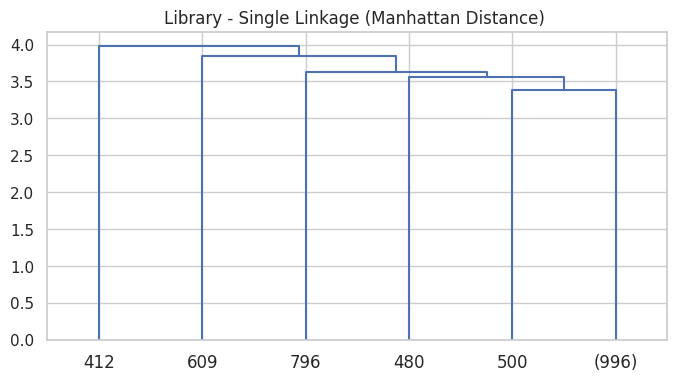

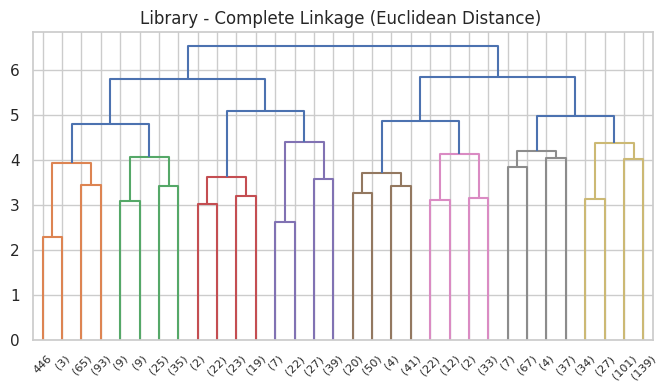

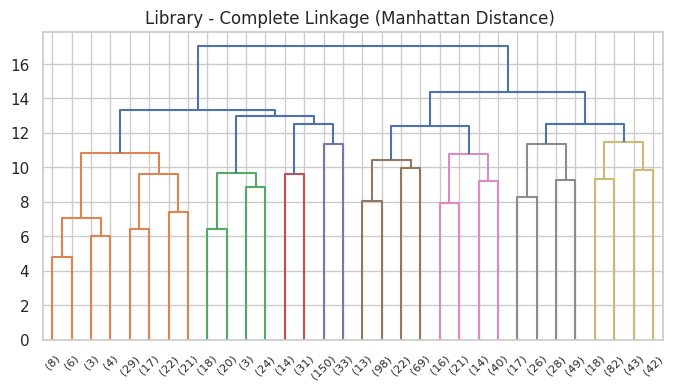

In [ ]:
# Single Linkage Euclidean
plt.figure(figsize=(8, 4))
dendrogram(linked_single_eu, labels=data.index, truncate_mode='level', orientation='top', p=4)
plt.title('Library - Single Linkage (Euclidean Distance) ')
plt.show()

# Single Linkage Manhattan
plt.figure(figsize=(8, 4))
dendrogram(linked_single_mh, labels=data.index, truncate_mode='level', orientation='top', p=4)
plt.title('Library - Single Linkage (Manhattan Distance) ')
plt.show()

# Complete Linkage Euclidean
plt.figure (figsize=(8, 4))
dendrogram(linked_complete_eu, labels=data.index, truncate_mode='level', orientation='top', p=4)
plt.title ('Library - Complete Linkage (Euclidean Distance) ')
plt.show()

# Complete Linkage Manhattan
plt.figure (figsize=(8, 4))
dendrogram(linked_complete_mh, labels=data.index, truncate_mode='level', orientation='top', p=4)
plt.title ('Library - Complete Linkage (Manhattan Distance) ')
plt.show()

### Hierarchical Manual

#### Score

In [ ]:
# Score HC Single Euclidean Manual

sil_score = silhouette_score(X, label_single_eu)
db_index = davies_bouldin_score(X, label_single_eu)
ch_score = calinski_harabasz_score(X, label_single_eu)
rand_index = adjusted_rand_score(y, label_single_eu)

print(f"Silhouette Score: {sil_score}")
print(f"Davies-Bouldin Index: {db_index}")
print(f"Calinski-Harabasz Index: {ch_score}")
print(f"Rand score: {rand_index}")

purity = purity_score(y, label_single_eu)
print("Purity Score:", purity)

Silhouette Score: -0.006176820231283161
Davies-Bouldin Index: 0.8093123386318782
Calinski-Harabasz Index: 1.476396777955852
Rand score: 0.00016380585082773693
Purity Score: 0.2817182817182817


In [ ]:
# Score HC Single Manhattan Manual

sil_score = silhouette_score(X, label_single_mh)
db_index = davies_bouldin_score(X, label_single_mh)
ch_score = calinski_harabasz_score(X, label_single_mh)
rand_index = adjusted_rand_score(y, label_single_mh)

print(f"Silhouette Score: {sil_score}")
print(f"Davies-Bouldin Index: {db_index}")
print(f"Calinski-Harabasz Index: {ch_score}")
print(f"Rand score: {rand_index}")

purity = purity_score(y, label_single_mh)
print("Purity Score:", purity)

Silhouette Score: 0.15433555824935866
Davies-Bouldin Index: 2.0449620787163907
Calinski-Harabasz Index: 183.5518906287919
Rand score: 0.08947042833860291
Purity Score: 0.4175824175824176


In [ ]:
# Score HC Complete Euclidean Manual

sil_score = silhouette_score(X, label_complete_eu)
db_index = davies_bouldin_score(X, label_complete_eu)
ch_score = calinski_harabasz_score(X, label_complete_eu)
rand_index = adjusted_rand_score(y, label_complete_eu)

print(f"Silhouette Score: {sil_score}")
print(f"Davies-Bouldin Index: {db_index}")
print(f"Calinski-Harabasz Index: {ch_score}")
print(f"Rand score: {rand_index}")

purity = purity_score(y, label_complete_eu)
print("Purity Score:", purity)

Silhouette Score: 0.14168550478136072
Davies-Bouldin Index: 1.8259757475254828
Calinski-Harabasz Index: 175.94280392461422
Rand score: 0.04196890841033513
Purity Score: 0.38961038961038963


In [ ]:
# Score HC Complete Manhattan Manual

sil_score = silhouette_score(X, label_complete_mh)
db_index = davies_bouldin_score(X, label_complete_mh)
ch_score = calinski_harabasz_score(X, label_complete_mh)
rand_index = adjusted_rand_score(y, label_complete_mh)

print(f"Silhouette Score: {sil_score}")
print(f"Davies-Bouldin Index: {db_index}")
print(f"Calinski-Harabasz Index: {ch_score}")
print(f"Rand score: {rand_index}")

purity = purity_score(y, label_complete_mh)
print("Purity Score:", purity)

Silhouette Score: 0.15433555824935866
Davies-Bouldin Index: 2.0449620787163907
Calinski-Harabasz Index: 183.5518906287919
Rand score: 0.08947042833860291
Purity Score: 0.4175824175824176


| **Metode**                   | **Silhouette Score** | **Davies-Bouldin Index** | **Calinski-Harabasz Index** | **Rand Score** | **Purity Score** |
| ---------------------------- | -------------------- | ------------------------ | --------------------------- | -------------- | ---------------- |
| HC Single Euclidean Manual   | -0.00298             | 0.75418                  | 1.74158                     | -0.000077      | 0.28072          |
| HC Single Manhattan Manual   | 0.12776              | 2.10939                  | 173.70221                   | 0.06037        | 0.38561          |
| HC Complete Euclidean Manual | 0.13908              | 2.32269                  | 188.19509                   | 0.08407        | 0.42258          |
| HC Complete Manhattan Manual | 0.12776              | 2.10939                  | 173.70221                   | 0.06037        | 0.38561          |



Analisis Singkat:
- Silhouette Score tertinggi dimiliki oleh HC Complete Euclidean Manual, menunjukkan bahwa cluster yang dibentuk cukup terpisah dan kompak.

- Davies-Bouldin Index (DBI) terendah ada pada HC Single Euclidean, tapi metode ini memiliki Silhouette yang negatif dan CHI sangat rendah, mengindikasikan clustering yang buruk.

- Calinski-Harabasz Index (CHI) tertinggi juga dimiliki oleh HC Complete Euclidean Manual, memperkuat indikasi pemisahan cluster yang baik.

- Rand Score dan Purity Score tertinggi juga diperoleh oleh HC Complete Euclidean Manual, yang menunjukkan kesesuaian hasil clustering dengan label asli.

Kesimpulan:

`Model HC Complete Euclidean Manual` merupakan metode paling unggul berdasarkan evaluasi. Ia unggul di semua aspek penting seperti Silhouette Score, Calinski-Harabasz Index, Rand Score, dan Purity Score. Meskipun DBI-nya tidak paling rendah, nilai tersebut masih wajar dan tidak mengurangi kualitas model secara keseluruhan.

#### Dendogram

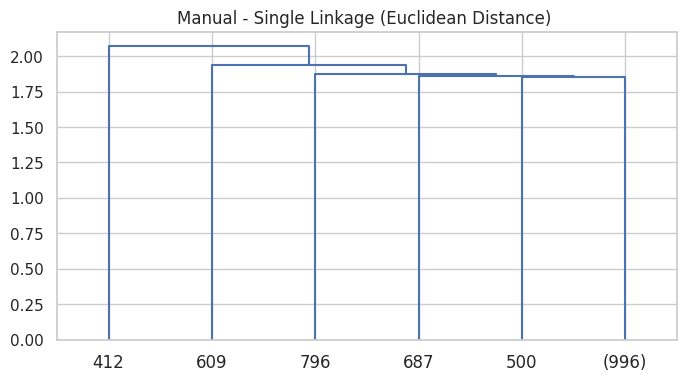

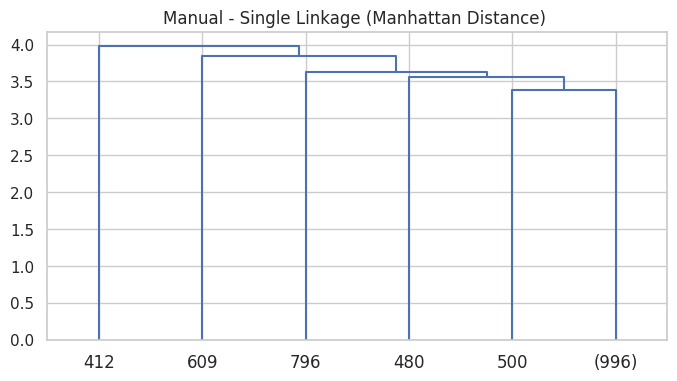

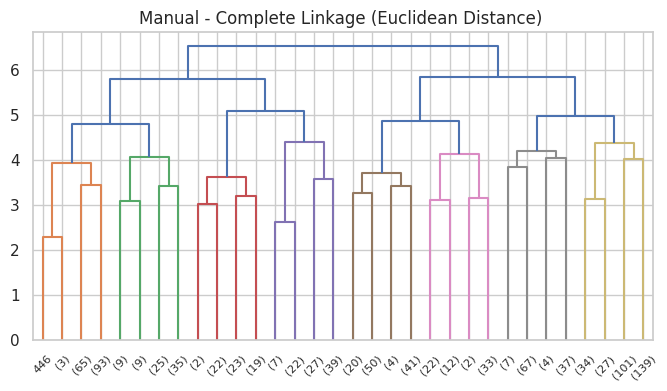

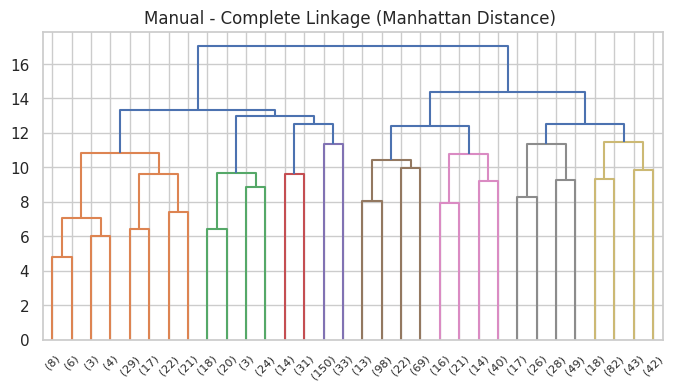

In [ ]:
# Manual Single Linkage Euclidean
plt.figure(figsize=(8, 4))
dendrogram(matrix_single_eu, labels=data.index, truncate_mode='level', orientation='top', p=4)
plt.title('Manual - Single Linkage (Euclidean Distance) ')
plt.show()

# Manual Single Linkage Manhattan
plt.figure(figsize=(8, 4))
dendrogram(matrix_single_mh, labels=data.index, truncate_mode='level', orientation='top', p=4)
plt.title('Manual - Single Linkage (Manhattan Distance) ')
plt.show()

# Manual Complete Linkage Euclidean
plt.figure (figsize=(8, 4))
dendrogram(linked_complete_eu, labels=data.index, truncate_mode='level', orientation='top', p=4)
plt.title ('Manual - Complete Linkage (Euclidean Distance) ')
plt.show()

# Manual Complete Linkage Manhattan
plt.figure (figsize=(8, 4))
dendrogram(linked_complete_mh, labels=data.index, truncate_mode='level', orientation='top', p=4)
plt.title ('Manual - Complete Linkage (Manhattan Distance) ')
plt.show()

### Beberapa Hal yang Mungkin/Dapat Menjadi Alasan Mengapa HC Complete dengan Euclidean Lebih Baik pada Data Online Retail

Metode Hierarchical Clustering dengan *Complete linkage* dan *Euclidean distance* menunjukkan performa terbaik dalam eksperimen menggunakan data **Online Retail** dari UCI yang telah dipraproses menjadi sepenuhnya numerik.

Beberapa alasan yang relevan dengan jenis datanya adalah:

- **Complete linkage membentuk klaster yang lebih padat dan terpisah dengan baik**, sehingga efektif dalam menangkap variasi perilaku pembelian pelanggan. Ini sangat berguna pada data transaksi ritel, di mana distribusi perilaku bisa sangat heterogen dan outlier bisa mengganggu jika menggunakan metode linkage lain seperti single linkage.

- **Euclidean distance menjadi sangat cocok digunakan setelah semua fitur dikonversi ke bentuk numerik dan dinormalisasi**, karena memungkinkan pengukuran jarak antar data berdasarkan geometri multivariat yang akurat. Dengan demikian, kemiripan antar transaksi atau pelanggan dapat dihitung secara objektif dan konsisten.

Kombinasi ini memungkinkan model menangkap struktur alami dalam data, menghasilkan pemisahan klaster yang lebih bermakna yang ditunjukkan oleh nilai Silhouette dan Calinski-Harabasz Index, serta memiliki kesesuaian yang lebih baik terhadap label aktual atau segmentasi yang diinginkan, hal ini ditunjukkan oleh Rand Score dan Purity Score.


## Hasil Evaluasi
Hasil clustering yang kurang optimal dapat disebabkan oleh berbagai faktor, salah satunya adalah karakteristik data yang digunakan. Pada dataset seperti Online Retail, struktur datanya mungkin belum cukup mendukung pembentukan klaster yang jelas. Hal ini bisa terjadi karena fitur-fitur yang tersedia belum cukup representatif untuk membedakan kelompok yang bermakna, baik dari sisi statistik maupun bisnis. Selain itu, tingginya variasi perilaku pelanggan dan adanya noise dalam data transaksi juga dapat mempersulit proses segmentasi. Oleh karena itu, hasil clustering yang kurang baik tidak selalu mencerminkan kelemahan algoritma, tetapi juga bisa menunjukkan perlunya eksplorasi lebih lanjut terhadap kualitas data dan pemilihan fitur yang digunakan.

## Kesimpulan

# **PCA**

## data PCA

In [ ]:
X = data.copy()

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

print(f"Jumlah komponen PCA: {pca.n_components_}")

Jumlah komponen PCA: 10


`X_pca` adalah hasil transformasi data dengan PCA yang mempertahankan total variansi ≥ 95%, artinya jumlah komponen yang dipilih otomatis oleh PCA adalah sebanyak mungkin hingga kumulatif variansinya mencapai minimal 95%. Ini bertujuan untuk mengurangi dimensi tanpa kehilangan terlalu banyak informasi.

In [ ]:
pca2d = PCA(n_components=2)
X_pca2d = pca2d.fit_transform(X)

print(f"Jumlah komponen PCA: {pca2d.n_components_}")

Jumlah komponen PCA: 2


Sementara itu, `X_pca2d` adalah hasil transformasi dari PCA dengan jumlah komponen tetap = 2, yaitu dua komponen utama terbaik berdasarkan variansi tertinggi. Tujuannya adalah untuk visualisasi dan eksplorasi struktur data dalam ruang dua dimensi.

## Kmeans

modeling kmeans menggunakan data `X_pca` dan `X_pca2d` yang telah dibuat

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

In [ ]:
kmeans2d = KMeans(n_clusters=4, random_state=42)
kmeans_labels2d = kmeans2d.fit_predict(X_pca2d)

## Hierarchical

modeling Hierarchical Clustering Complete dengan Euclidean menggunakan data `X_pca` dan `X_pca2d` yang telah dibuat

In [ ]:
hc = AgglomerativeClustering(n_clusters=4, linkage='complete', metric='euclidean')
hc_labels = hc.fit_predict(X_pca)

In [ ]:
hc2d = AgglomerativeClustering(n_clusters=4, linkage='complete', metric='euclidean')
hc2d_labels = hc2d.fit_predict(X_pca2d)

## Evaluasi untuk PCA

In [ ]:
def evaluate_clustering(X, y_true, y_pred):
    sil_score = silhouette_score(X, y_pred)
    db_index = davies_bouldin_score(X, y_pred)
    ch_score = calinski_harabasz_score(X, y_pred)
    rand_index = adjusted_rand_score(y_true, y_pred)
    purity = purity_score(y_true, y_pred)

    print(f"Silhouette Score: {sil_score}")
    print(f"Davies-Bouldin Index: {db_index}")
    print(f"Calinski-Harabasz Index: {ch_score}")
    print(f"Rand score: {rand_index}")
    print(f"Purity Score: {purity}")

Dataset hasil transformasi X_pca dan X_pca2d digunakan sebagai input untuk evaluasi metode clustering, dengan tujuan mengukur performa menggunakan lima metrik: Silhouette Score, Davies-Bouldin Index (DBI), Calinski-Harabasz Score (CH Score), Rand Index, dan Purity Score.

In [ ]:
print('Kmeans PCA 95%')
evaluate_clustering(X_pca, label, kmeans_labels)

print('\nKmeans PCA 2D')
evaluate_clustering(X_pca2d, label, kmeans_labels2d)

print('\nHC PCA 95%')
evaluate_clustering(X_pca, label, hc_labels)

print('\nHC PCA 2D')
evaluate_clustering(X_pca2d, label, hc2d_labels)

Kmeans PCA 95%
Silhouette Score: 0.24030942219999274
Davies-Bouldin Index: 1.3952112271146664
Calinski-Harabasz Index: 289.4624659062483
Rand score: 0.07777116988316186
Purity Score: 0.41058941058941056

Kmeans PCA 2D
Silhouette Score: 0.4131612805126757
Davies-Bouldin Index: 0.8565655052124374
Calinski-Harabasz Index: 972.1416806803647
Rand score: 0.08397344583210668
Purity Score: 0.42157842157842157

HC PCA 95%
Silhouette Score: 0.12977006249987671
Davies-Bouldin Index: 1.929662973117105
Calinski-Harabasz Index: 160.03444235306145
Rand score: 0.0488513939075941
Purity Score: 0.36063936063936064

HC PCA 2D
Silhouette Score: 0.3214579732666695
Davies-Bouldin Index: 0.9081585325381794
Calinski-Harabasz Index: 649.6132109392287
Rand score: 0.05634317791017407
Purity Score: 0.3876123876123876


---

### 1. Apakah PCA diperlukan? dan Mengapa?

**Jawaban:**
**Iya, PCA diperlukan**, tetapi penggunaannya harus disesuaikan dengan tujuan analisis dan konteks data.

**Alasan:**

* **Peningkatan Kualitas Clustering (terutama PCA 2D):**
  Meskipun PCA dengan komponen yang mempertahankan 95% variansi memberikan sedikit perbaikan dalam metrik evaluasi seperti Silhouette dan Davies-Bouldin, hasil yang jauh lebih baik justru terlihat ketika jumlah komponen dikurangi ke dua dimensi. Ini menunjukkan bahwa pada dataset ini, *proyeksi ke ruang 2D justru memperjelas pemisahan antar cluster*, bahkan jika informasi variansi yang dipertahankan jauh lebih sedikit.

* **Reduksi Dimensi & Efisiensi:**
  Menggunakan PCA mengurangi beban dimensi dari data asli yang kompleks menjadi lebih sederhana. Hal ini tidak hanya mempercepat proses komputasi tetapi juga membantu mengurangi noise yang dapat mengganggu proses clustering.

* **Manfaat Khusus untuk Visualisasi dan HC:**
  Proyeksi ke dua dimensi juga memudahkan visualisasi hasil cluster dan tampak membantu metode seperti Agglomerative Clustering yang sebelumnya menunjukkan kualitas rendah, menjadi sedikit lebih stabil. Ini menandakan bahwa *penghilangan korelasi antar fitur* oleh PCA cukup membantu metode yang sensitif terhadap jarak antar titik.

Namun, **perbaikan performa clustering secara umum tetap terbatas**, terutama pada metrik eksternal seperti Rand Score dan Purity, yang menunjukkan bahwa meskipun PCA membantu, struktur alami data tetap tidak membentuk cluster yang sangat jelas.

---

### 2. Kelebihan dan Kekurangan Penggunaan PCA pada Dataset

#### Kelebihan PCA:

* **Reduksi Dimensi:**
  Mengurangi kompleksitas dataset dan menghilangkan redundansi antar fitur.

* **Peningkatan Efisiensi dan Performa Algoritma:**
  Mengurangi waktu komputasi serta membantu metode clustering bekerja lebih optimal, terutama dalam proyeksi dimensi rendah.

* **Mempermudah Visualisasi:**
  Proyeksi 2D memudahkan eksplorasi dan pemetaan visual dari cluster yang terbentuk.

* **Perbaikan Kualitas Clustering (terutama dalam proyeksi 2D):**
  Beberapa metrik evaluasi menunjukkan peningkatan yang lebih jelas ketika menggunakan PCA dua dimensi dibanding mempertahankan banyak komponen.

#### Kekurangan PCA:

* **Kehilangan Interpretabilitas:**
  Komponen PCA sulit dijelaskan secara bisnis karena merupakan kombinasi linear dari fitur asli.

* **Fokus pada Variansi, Bukan Segmentasi:**
  PCA mengutamakan fitur dengan variansi tinggi, yang belum tentu relevan untuk pemisahan cluster.

* **Hasil Tetap Terbatas:**
  Meski ada peningkatan, hasil clustering secara umum tetap tidak optimal, yang menandakan bahwa PCA bukan solusi penuh atas kompleksitas struktur data.

---

# (Tambahan) **Analisis Segmentasi Customer Hasil Clustering**

Kita akan melakukan analisis lanjutan untuk mencari tahu bagaimana karakteristik pelanggan dalam masing masing kluster yang sudah di buat dengan PCA 2d (hasil evaluasi terbaik)

## Load Data

In [ ]:
data_analisis = data.copy()

In [ ]:
data_analisis

,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing
0,1,1,2.030280,1,-0.202423,1.973391,-0.473324,False,False,False,False,True,False,False,False,False
1,0,1,1.254885,1,-0.202423,-0.738594,-1.584262,False,False,True,False,False,False,False,False,False
2,1,1,0.339806,0,-1.100537,0.617398,0.314899,False,False,False,True,False,False,False,False,False
3,0,0,-1.056216,1,-1.100537,-0.738594,0.926293,False,False,False,False,False,True,False,False,False
4,1,0,-0.094863,1,-0.202423,-0.738594,-1.584262,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,1,0,-0.613367,0,-1.100537,-0.738594,0.926293,True,False,False,False,False,False,False,False,False
997,0,0,-1.056216,0,-0.202423,-0.738594,0.314899,True,False,False,False,False,False,False,False,False
998,0,0,-0.163103,1,-0.202423,-0.738594,-1.584262,True,False,False,False,False,False,False,False,False
999,0,1,0.714014,1,-0.202423,-0.738594,-0.473324,True,False,False,False,False,False,False,False,False


## Reverse Transform Data

yang pertama kita akan kembalikan kolom yang sudah di ohe menjadi 1 kolom kategorikal lagi ("Profession") seperti sebelumnya

In [ ]:
ohe_cols =  ["Profession_Artist","Profession_Doctor", "Profession_Engineer", "Profession_Entertainment",	"Profession_Executive",	"Profession_Healthcare",	"Profession_Homemaker",	"Profession_Lawyer", "Profession_Marketing"]

data_analisis['Profession'] = data_analisis[ohe_cols].idxmax(axis=1)
data_analisis['Profession'] = data_analisis['Profession'].str.replace('Profession_', '')

data_analisis.drop(ohe_cols, axis=1, inplace=True)

data_analisis

,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Profession
0,1,1,2.030280,1,-0.202423,1.973391,-0.473324,Executive
1,0,1,1.254885,1,-0.202423,-0.738594,-1.584262,Engineer
2,1,1,0.339806,0,-1.100537,0.617398,0.314899,Entertainment
3,0,0,-1.056216,1,-1.100537,-0.738594,0.926293,Healthcare
4,1,0,-0.094863,1,-0.202423,-0.738594,-1.584262,Artist
...,...,...,...,...,...,...,...,...
996,1,0,-0.613367,0,-1.100537,-0.738594,0.926293,Artist
997,0,0,-1.056216,0,-0.202423,-0.738594,0.314899,Artist
998,0,0,-0.163103,1,-0.202423,-0.738594,-1.584262,Artist
999,0,1,0.714014,1,-0.202423,-0.738594,-0.473324,Artist


Selanjutnya adalah unscale kolom kolom yang sudah di lakukan standard scaling di bagian preprocessing

In [ ]:
scaled_cols = ["Age", "Work_Experience", "Family_Size", "Spending_Score"]

# Inverse scaling
data_analisis[scaled_cols] = scaler.inverse_transform(data_analisis[scaled_cols])

lalu yang langkah reverse trasnformayang terakhir adalah invers log transformnya dengan expm1

In [ ]:
# Kalau pakai log1p sebelumnya:
log_cols = ["Age", "Work_Experience", "Family_Size"]

# Inverse log1p
data_analisis[log_cols] = np.expm1(data_analisis[log_cols])

bisa dilihat hasilnya angka pada data sudah masuk akal untuk setiap kolomnya sesuai dengan data awalnya

In [ ]:
data_analisis

,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Profession
0,1,1,87.0,1,1.0,2.0,2.0,Executive
1,0,1,65.0,1,1.0,0.0,1.0,Engineer
2,1,1,46.0,0,0.0,1.0,3.0,Entertainment
3,0,0,27.0,1,0.0,0.0,4.0,Healthcare
4,1,0,39.0,1,1.0,0.0,1.0,Artist
...,...,...,...,...,...,...,...,...
996,1,0,32.0,0,0.0,0.0,4.0,Artist
997,0,0,27.0,0,1.0,0.0,3.0,Artist
998,0,0,38.0,1,1.0,0.0,1.0,Artist
999,0,1,53.0,1,1.0,0.0,2.0,Artist


## Menambahkan Kolom "Cluster" Sebagai Label

In [ ]:
data_analisis['Cluster'] = kmeans_labels2d

In [ ]:
data_analisis['Cluster'].value_counts()

,count
Cluster,
0,303
2,274
3,271
1,153


In [ ]:
print(f"\n=== Cluster {0} ===")
display(data_analisis[data_analisis['Cluster'] == 0].describe())


=== Cluster 0 ===


,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Cluster
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.0
mean,0.508251,0.531353,46.706271,0.735974,2.752475,0.069307,1.415842,0.0
std,0.500759,0.499842,15.063976,0.441543,3.247228,0.254395,0.544703,0.0
min,0.000000,0.000000,22.000000,0.000000,0.000000,0.000000,1.000000,0.0
25%,0.000000,0.000000,37.000000,0.000000,1.000000,0.000000,1.000000,0.0
50%,1.000000,1.000000,43.000000,1.000000,1.000000,0.000000,1.000000,0.0
75%,1.000000,1.000000,53.000000,1.000000,5.000000,0.000000,2.000000,0.0
max,1.000000,1.000000,87.000000,1.000000,10.000000,1.000000,4.000000,0.0


In [ ]:
print(f"\n=== Cluster {1} ===")
display(data_analisis[data_analisis['Cluster'] == 1].describe())


=== Cluster 1 ===


,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Cluster
count,153.000000,153.0,153.000000,153.000000,153.000000,153.000000,153.000000,153.0
mean,0.549020,1.0,66.568627,0.699346,0.869281,1.653595,2.313725,1.0
std,0.499225,0.0,11.670230,0.460048,1.422067,0.529651,0.622713,0.0
min,0.000000,1.0,33.000000,0.000000,0.000000,0.000000,1.000000,1.0
25%,0.000000,1.0,58.000000,0.000000,0.000000,1.000000,2.000000,1.0
50%,1.000000,1.0,67.000000,1.000000,1.000000,2.000000,2.000000,1.0
75%,1.000000,1.0,76.000000,1.000000,1.000000,2.000000,3.000000,1.0
max,1.000000,1.0,87.000000,1.000000,9.000000,2.000000,4.000000,1.0


In [ ]:
print(f"\n=== Cluster {2} ===")
display(data_analisis[data_analisis['Cluster'] == 2].describe())


=== Cluster 2 ===


,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Cluster
count,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.0
mean,0.532847,0.131387,27.788321,0.332117,2.452555,0.021898,3.781022,2.0
std,0.499833,0.338441,6.347600,0.471834,3.113178,0.146618,1.130434,0.0
min,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,1.000000,2.0
25%,0.000000,0.000000,23.000000,0.000000,0.000000,0.000000,3.000000,2.0
50%,1.000000,0.000000,28.000000,0.000000,1.000000,0.000000,4.000000,2.0
75%,1.000000,0.000000,32.000000,1.000000,4.000000,0.000000,4.000000,2.0
max,1.000000,1.000000,50.000000,1.000000,9.000000,1.000000,7.000000,2.0


In [ ]:
print(f"\n=== Cluster {3} ===")
display(data_analisis[data_analisis['Cluster'] == 3].describe())


=== Cluster 3 ===


,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Cluster
count,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.0
mean,0.660517,0.985240,45.335793,0.719557,1.653137,1.036900,3.446494,3.0
std,0.474410,0.120815,10.395234,0.450047,2.308916,0.582558,1.090318,0.0
min,0.000000,0.000000,22.000000,0.000000,0.000000,0.000000,1.000000,3.0
25%,0.000000,1.000000,38.000000,0.000000,0.000000,1.000000,3.000000,3.0
50%,1.000000,1.000000,46.000000,1.000000,1.000000,1.000000,3.000000,3.0
75%,1.000000,1.000000,51.500000,1.000000,1.000000,1.000000,4.000000,3.0
max,1.000000,1.000000,81.000000,1.000000,10.000000,2.000000,7.000000,3.0


In [ ]:
# Persentase Pekerjaan tiap Cluster
pd.crosstab(data_analisis['Cluster'], data_analisis['Profession'], normalize='index') * 100

Profession,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing
Cluster,,,,,,,,,
0,42.244224,8.910891,7.590759,15.511551,1.650165,5.610561,3.630363,11.221122,3.630363
1,31.372549,1.960784,6.535948,2.614379,20.261438,0.653595,0.000000,33.986928,2.614379
2,10.948905,12.773723,6.569343,9.854015,2.189781,47.810219,4.014599,0.364964,5.474453
3,43.542435,9.225092,8.856089,14.760148,14.022140,3.690037,2.583026,1.476015,1.845018


## **Hasil Analisis**

---

## **Analisis Karakteristik Customer per Cluster**

---

### **1. Cluster 0 — “Low-Spending Middle-Aged”**

#### Karakteristik:

* **Umur rata-rata:** \~47 tahun
* **Mayoritas sudah menikah** (53%)
* **Tingkat pendidikan cukup tinggi** (73% lulusan)
* **Work Experience:** Rata-rata 2.75 tahun (cukup berpengalaman)
* **Spending Score:** **Sangat rendah (0.07)** – hampir semua termasuk low spender
* **Family Size:** kecil, rata-rata 1–2 orang
* **Gender:** hampir seimbang
* **Profesi dominan:**

  * **Artist (42%)**
  * **Entertainment (15%)**
  * **Lawyer (11%)**

**“Silent Spenders”**
 Mereka tergolong mapan secara usia dan pendidikan, tapi sangat hemat atau tidak banyak melakukan pembelian. Banyak dari mereka bekerja di bidang kreatif dan hukum.


---

### **3. Cluster 1 — “Older Loyal Professionals”**

#### Karakteristik:

* **Umur rata-rata:** \~66 tahun → kelompok tertua
* **Semua sudah menikah (100%)**
* **Graduated:** 70%
* **Work Experience:** rendah (0.8 tahun, kemungkinan sudah pensiun)
* **Spending Score:** **Sangat tinggi (1.65)**
* **Family Size:** sedang (2–3 orang)
* **Gender:** agak lebih banyak pria (55%)
* **Profesi dominan:**

  * **Lawyer (34%)**
  * **Artist (31%)**
  * **Executive (20%)**

**“Mature Big Spenders”**
Usia tua, sudah mapan, dan sangat loyal sebagai pembeli. Kemungkinan mereka punya pendapatan pasif dan gaya hidup konsumtif.

---

### **3. Cluster 2 — “Young Health-Focused Singles”**

#### Karakteristik:

* **Umur rata-rata:** \~28 tahun → paling muda
* **Hampir semua belum menikah (13%)**
* **Graduated:** rendah (33%)
* **Work Experience:** 2.45 tahun
* **Spending Score:** **Paling rendah (0.02)**
* **Family Size:** besar (rata-rata 3.8)
* **Gender:** seimbang
* **Profesi dominan:**

  * **Healthcare (48%)**
  * **Artist** juga ada (11%)


**“Young Essentials”**
 Generasi muda yang fokus pada karier di bidang kesehatan, belum banyak pengeluaran besar, mungkin baru mulai mandiri atau masih menabung.

---

### **4. Cluster 3 — “Middle-Aged Active Spenders”**

#### Karakteristik:

* **Umur rata-rata:** \~45 tahun
* **Mayoritas sudah menikah (98%)**
* **Graduated:** 72%
* **Work Experience:** 1.65 tahun
* **Spending Score:** **Sedang-Tinggi (1.03)**
* **Family Size:** besar (3.4 anggota)
* **Gender:** mayoritas pria (66%)
* **Profesi dominan:**

  * **Artist (43%)**
  * **Entertainment (14%)**
  * **Executive (14%)**


**“Creative Families”**
 Orang dewasa aktif dengan latar belakang seni/eksekutif, memiliki keluarga besar dan pengeluaran cukup tinggi, mencerminkan gaya hidup aktif & kreatif.

---

## **Rangkuman Tabel**

| Cluster | Julukan             | Umur Rata-rata | Spending Score | Dominan Profesi       |
| ------- | ------------------- | -------------- | -------------- | --------------------- |
| 0       | Silent Spenders     | 47             | Sangat rendah  | Artist, Entertainment |
| 1       | Mature Big Spenders | 66             | Sangat tinggi  | Lawyer, Executive     |
| 2       | Young Essentials    | 28             | Sangat rendah  | Healthcare            |
| 3       | Creative Families   | 45             | Sedang-tinggi  | Artist, Executive     |



# TERIMA KASIH :)